# Data Description

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

## Data fields

*   DBNOs - Number of enemy players knocked.
*   assists - Number of enemy players this player damaged that were killed by teammates.

*   boosts - Number of boost items used.

*   damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.m

*   headshotKills - Number of enemy players killed with headshots.

*   heals - Number of healing items used.
*   Id - Player’s Id
*   killPlace - Ranking in match of number of enemy players killed.
*   killPoints - Kills-based external ranking of players. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
*   killStreaks - Max number of enemy players killed in a short amount of time.
*   kills - Number of enemy players killed.

*   longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
*   matchDuration - Duration of match in seconds.
*   matchId - ID to identify matches. There are no matches that are in both the training and testing set.
*   matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
*rankPoints - Elo-like ranking of players. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes the place of “None”.

*   revives - Number of times this player revived teammates.
rideDistance - Total distance traveled in vehicles measured in meters.

*   roadKills - Number of kills while in a vehicle.
swimDistance - Total distance traveled by swimming measured in meters.
*   teamKills - Number of times this player killed a teammate.

*   vehicleDestroys - Number of vehicles destroyed.
*   weaponsAcquired - Number of weapons picked up.
*  winPoints - Win-based external ranking of players. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”. 
*  groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.  
*   maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
*   winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.










# Importing the Libraries

In [682]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.stats import kurtosis,skew
import matplotlib.pyplot as plt
import math
import random
import statistics as st
import statsmodels.api as sm
import pylab as py
random.seed = 42

# Dataset Details

## Reading the Dataset

In [683]:
mod_df=pd.read_csv('data.csv')

In [684]:
mod_df.shape

(44159, 30)

## Sample of Dataset

In [685]:
df = mod_df.sample(frac =.009)
df.shape

(397, 30)

In [686]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 27893 to 34831
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       397 non-null    int64  
 1   Id               397 non-null    object 
 2   groupId          397 non-null    object 
 3   matchId          397 non-null    object 
 4   assists          397 non-null    float64
 5   boosts           397 non-null    float64
 6   damageDealt      397 non-null    float64
 7   DBNOs            397 non-null    float64
 8   headshotKills    397 non-null    float64
 9   heals            397 non-null    float64
 10  killPlace        397 non-null    float64
 11  killPoints       397 non-null    float64
 12  kills            397 non-null    float64
 13  killStreaks      397 non-null    float64
 14  longestKill      397 non-null    float64
 15  matchDuration    397 non-null    float64
 16  matchType        397 non-null    object 
 17  maxPlace  

In [687]:
df.head().T

27893           11506  ...           40609           35047
Unnamed: 0              4373037         1129914  ...         4322850         3365734
Id               a79e0f363bc581  aadee1d4e20be0  ...  ebe51b88e978b8  daa61093629f64
groupId          648f284d7dd1a6  07105fa566e9ca  ...  ed1c97ef4aaac8  f821dae08776cb
matchId          2e74fc24bc1bc8  20315d1baba1b6  ...  45114f703dbd2a  9733c783a5ee59
assists                       0               0  ...               0               0
boosts                        1               3  ...               1               0
damageDealt               46.75           382.8  ...           90.65               0
DBNOs                         0               3  ...               0               0
headshotKills                 0               1  ...               0               0
heals                         0               2  ...               0               0
killPlace                    60               4  ...              85              64
killPoints                 1347               0  ...               0            1101
kills                         0               5  ...               0               0
killStreaks                   0               3  ...               0               0
longestKill                   0           55.75  ...               0               0
matchDuration              1374            1924  ...            1508            1285
matchType               duo-fpp       squad-fpp  ...         duo-fpp         duo-fpp
maxPlace                     50              31  ...              48              50
numGroups                    50              29  ...              46              50
rankPoints                   -1            1496  ...            1562              -1
revives                       0               0  ...               0               0
rideDistance              334.2            6639  ...               0               0
roadKills                     0               0  ...               0               0
swimDistance                  0               0  ...               0               0
teamKills                     0               0  ...               0               0
vehicleDestroys               0               0  ...               0               0
walkDistance              802.9            1285  ...           37.96           353.1
weaponsAcquired               4               5  ...               3               3
winPoints                  1507               0  ...               0            1487
winPlacePerc             0.5918          0.4667  ...          0.0851          0.4286

[30 rows x 5 columns]

## Statistical Analysis

In [688]:
df.describe().T

count          mean  ...         75%        max
Unnamed: 0       397.0  2.173560e+06  ...  3340680.00  4429938.0
assists          397.0  2.090680e-01  ...        0.00        3.0
boosts           397.0  1.264484e+00  ...        2.00       11.0
damageDealt      397.0  1.323103e+02  ...      161.70     1547.0
DBNOs            397.0  6.423174e-01  ...        1.00        9.0
headshotKills    397.0  2.342569e-01  ...        0.00        4.0
heals            397.0  1.488665e+00  ...        2.00       20.0
killPlace        397.0  4.705793e+01  ...       69.00       98.0
killPoints       397.0  5.270957e+02  ...     1160.00     1851.0
kills            397.0  9.647355e-01  ...        1.00       11.0
killStreaks      397.0  5.340050e-01  ...        1.00        4.0
longestKill      397.0  2.437876e+01  ...       21.04      559.1
matchDuration    397.0  1.599458e+03  ...     1869.00     2176.0
maxPlace         397.0  4.449874e+01  ...       49.00       99.0
numGroups        397.0  4.280856e+01  ...       47.00       98.0
rankPoints       397.0  8.647204e+02  ...     1500.00     2384.0
revives          397.0  1.586902e-01  ...        0.00        3.0
rideDistance     397.0  6.830777e+02  ...      245.20    11650.0
roadKills        397.0  2.518892e-03  ...        0.00        1.0
swimDistance     397.0  1.748504e+00  ...        0.00      229.4
teamKills        397.0  2.267003e-02  ...        0.00        1.0
vehicleDestroys  397.0  2.518892e-03  ...        0.00        1.0
walkDistance     397.0  1.204534e+03  ...     2045.00     6757.0
weaponsAcquired  397.0  3.619647e+00  ...        5.00       12.0
winPoints        397.0  6.377834e+02  ...     1497.00     1849.0
winPlacePerc     397.0  4.867146e-01  ...        0.75        1.0

[26 rows x 8 columns]

In [689]:
df.describe(include='object').T

count unique             top freq
Id          397    397  ea39e9630cca0a    1
groupId     397    397  14e2292b67fe29    1
matchId     397    397  801983b83caf34    1
matchType   397      8       squad-fpp  162

In [690]:
df.dtypes

Unnamed: 0           int64
Id                  object
groupId             object
matchId             object
assists            float64
boosts             float64
damageDealt        float64
DBNOs              float64
headshotKills      float64
heals              float64
killPlace          float64
killPoints         float64
kills              float64
killStreaks        float64
longestKill        float64
matchDuration      float64
matchType           object
maxPlace           float64
numGroups          float64
rankPoints         float64
revives            float64
rideDistance       float64
roadKills          float64
swimDistance       float64
teamKills          float64
vehicleDestroys    float64
walkDistance       float64
weaponsAcquired    float64
winPoints          float64
winPlacePerc       float64
dtype: object

In [691]:
df.shape

(397, 30)

In [692]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

# **Missing Value Imputaion**

Real-world data often has missing values. Data can have missing values for a number of reasons such as observations 
that were not recorded and data corruption. 

**Impact:** 

• Handling missing data is important as many machine learning algorithms do 
not support data with missing values. 

**Solution:** 

• Remove rows with missing data from your dataset. 

• Impute missing values with mean/median values in your dataset. 

**Note:**

• Use business knowledge to take separate approach for each variable 

• It is advisable to impute instead of remove in case of small sample size or 
large proportion of observations with missing values

## **Missing Value Imputation Methods**

1. **Impute with ZERO** 

     • Impute missing values with zero 

2. **Impute with Median/Mean/Mode**

     • For numerical variables, impute missing values with Mean or Median 

     • For categorical variables, impute missing values with Mode 

3. **Segment based imputation**

     • Identify relevant segments 

     • Calculate mean/median/mode of segments 

     • Impute the missing value according to the segments 

     • For example, we can say rainfall hardly varies for cities in a particular State 

     • In this case, we can impute missing rainfall value of a city with the average of that state 

In [693]:
missing_val = ['n/a', '-', 'NaN','?']
missing_val = ['n/a', '-', 'Not Provided','NaN','?']
df=df.replace(missing_val,np.nan)
df.head()

Unnamed: 0              Id  ... winPoints winPlacePerc
27893     4373037  a79e0f363bc581  ...    1507.0       0.5918
11506     1129914  aadee1d4e20be0  ...       0.0       0.4667
43474     4012906  c301f72d0fe714  ...    1495.0       0.7826
40609     4322850  ebe51b88e978b8  ...       0.0       0.0851
35047     3365734  daa61093629f64  ...    1487.0       0.4286

[5 rows x 30 columns]

**Observation:** we have declared the null values -----> n/a,-,?,NaN.

### missing values in each column

In [694]:
df.isnull().any(axis=0)

Unnamed: 0         False
Id                 False
groupId            False
matchId            False
assists            False
boosts             False
damageDealt        False
DBNOs              False
headshotKills      False
heals              False
killPlace          False
killPoints         False
kills              False
killStreaks        False
longestKill        False
matchDuration      False
matchType          False
maxPlace           False
numGroups          False
rankPoints         False
revives            False
rideDistance       False
roadKills          False
swimDistance       False
teamKills          False
vehicleDestroys    False
walkDistance       False
weaponsAcquired    False
winPoints          False
winPlacePerc       False
dtype: bool

**NOTE:** The above function ***dataset.isnull().any(axis=0)*** returns **Boolean Logic** for each column

If it returns 
1.   **True** ----> It has Missing Values
2.   **False**----> It doesn't have Missing Values



In [695]:
df.isnull().sum()

Unnamed: 0         0
Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

**NOTE:** The above function ***dataset.isnull().sum()*** returns the number of missing values in each column

**Observation:** There is only 1 outlier present in the dataset in WinPlacePerc Column

In [696]:
# Columns with all missing values
df.isnull().all(axis=0)

Unnamed: 0         False
Id                 False
groupId            False
matchId            False
assists            False
boosts             False
damageDealt        False
DBNOs              False
headshotKills      False
heals              False
killPlace          False
killPoints         False
kills              False
killStreaks        False
longestKill        False
matchDuration      False
matchType          False
maxPlace           False
numGroups          False
rankPoints         False
revives            False
rideDistance       False
roadKills          False
swimDistance       False
teamKills          False
vehicleDestroys    False
walkDistance       False
weaponsAcquired    False
winPoints          False
winPlacePerc       False
dtype: bool

**NOTE:** The above function ***dataset.isnull().all(axis=0)*** returns **Boolean Logic** for each column

If it returns **True** then Entire Column is having Missing Values else it returns **False**

In [697]:
df.isnull().describe(include='all').T

count unique    top freq
Unnamed: 0        397      1  False  397
Id                397      1  False  397
groupId           397      1  False  397
matchId           397      1  False  397
assists           397      1  False  397
boosts            397      1  False  397
damageDealt       397      1  False  397
DBNOs             397      1  False  397
headshotKills     397      1  False  397
heals             397      1  False  397
killPlace         397      1  False  397
killPoints        397      1  False  397
kills             397      1  False  397
killStreaks       397      1  False  397
longestKill       397      1  False  397
matchDuration     397      1  False  397
matchType         397      1  False  397
maxPlace          397      1  False  397
numGroups         397      1  False  397
rankPoints        397      1  False  397
revives           397      1  False  397
rideDistance      397      1  False  397
roadKills         397      1  False  397
swimDistance      397      1  False  397
teamKills         397      1  False  397
vehicleDestroys   397      1  False  397
walkDistance      397      1  False  397
weaponsAcquired   397      1  False  397
winPoints         397      1  False  397
winPlacePerc      397      1  False  397

### Removing Missing Values

**Original Dataset**

In [698]:
print("Contents of the Dataframe : ")
df

Contents of the Dataframe : 


Unnamed: 0              Id  ... winPoints winPlacePerc
27893     4373037  a79e0f363bc581  ...    1507.0       0.5918
11506     1129914  aadee1d4e20be0  ...       0.0       0.4667
43474     4012906  c301f72d0fe714  ...    1495.0       0.7826
40609     4322850  ebe51b88e978b8  ...       0.0       0.0851
35047     3365734  daa61093629f64  ...    1487.0       0.4286
...           ...             ...  ...       ...          ...
12875     2980836  a6aaba39114b37  ...    1465.0       0.1852
41643      783955  cdbd76f6c43034  ...    1553.0       0.0345
30294     2629283  4b7b3ee66afc9e  ...    1492.0       0.4667
29622     2734615  ebf4910ce1d4b0  ...       0.0       0.0851
34831     1131236  521f7f876fda71  ...    1491.0       0.7037

[397 rows x 30 columns]

**Modified Dataset**

In [699]:
df = df.loc[df['winPlacePerc'].notnull(), :]

In [700]:
df.shape

(397, 30)

In [701]:
df

Unnamed: 0              Id  ... winPoints winPlacePerc
27893     4373037  a79e0f363bc581  ...    1507.0       0.5918
11506     1129914  aadee1d4e20be0  ...       0.0       0.4667
43474     4012906  c301f72d0fe714  ...    1495.0       0.7826
40609     4322850  ebe51b88e978b8  ...       0.0       0.0851
35047     3365734  daa61093629f64  ...    1487.0       0.4286
...           ...             ...  ...       ...          ...
12875     2980836  a6aaba39114b37  ...    1465.0       0.1852
41643      783955  cdbd76f6c43034  ...    1553.0       0.0345
30294     2629283  4b7b3ee66afc9e  ...    1492.0       0.4667
29622     2734615  ebf4910ce1d4b0  ...       0.0       0.0851
34831     1131236  521f7f876fda71  ...    1491.0       0.7037

[397 rows x 30 columns]

**Observation:** rows which contain missing values are dropped

In [702]:
df.isnull().sum()

Unnamed: 0         0
Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

**Observation:** From above we can osberve that, there are no missing values in modified dataset

## original dataset column Vs modified datset column

#### winPlacePerc

In [703]:
print('original Column of winPlacePerc')
print('\t')
k=(df.winPlacePerc.unique())
print('********------> Length of modified column is', len(k), '<------********')
print('\t')
print(k)
print('\t')
print('****************************')
print('\t')
print('Modified Column of winPlacePerc')
print('\t')
k=df.winPlacePerc.unique()
print(k)
print('\t')
print('********-----> Length of modified column is', len(k), '<-----********')

original Column of winPlacePerc
	
********------> Length of modified column is 243 <------********
	
[0.5918 0.4667 0.7826 0.0851 0.4286 0.9167 0.0816 0.0638 0.4    0.1935
 0.1778 0.3    0.963  0.3704 0.5172 0.913  1.     0.9184 0.2692 0.2667
 0.1458 0.5    0.3226 0.117  0.2857 0.1702 0.4565 0.7333 0.7778 0.9643
 0.1875 0.4643 0.     0.4444 0.0208 0.6    0.0435 0.1786 0.7308 0.1111
 0.7917 0.9231 0.0385 0.7857 0.08   0.8043 0.5978 0.5385 0.8125 0.9579
 0.2    0.4333 0.2041 0.2143 0.1724 0.3077 0.96   0.1087 0.3846 0.3462
 0.6786 0.5426 0.0454 0.0741 0.28   0.75   0.6667 0.2414 0.1538 0.8846
 0.037  0.7292 0.6897 0.7959 0.4167 0.8367 0.8571 0.4828 0.8966 0.1071
 0.5652 0.88   0.9588 0.8298 0.7692 0.2553 0.234  0.4043 0.2128 0.2609
 0.7755 0.3478 0.3404 0.9787 0.3333 0.04   0.9592 0.8523 0.5368 0.6296
 0.2526 0.8222 0.2979 0.7037 0.7473 0.6552 0.3409 0.9462 0.5104 0.8132
 0.6538 0.8    0.8936 0.2391 0.0333 0.6222 0.0833 0.6042 0.7407 0.7253
 0.2917 0.9259 0.125  0.5333 0.6875 0.5714 0.64

# Categories of Data

In [704]:
cat=[]
num=[]
for col in df.columns:
  if (is_string_dtype(df[col])):
    cat.append(col)
  else:
    num.append(col)
print('categorical columns:', cat)
print()
print('numerical columns:', num)

categorical columns: ['Id', 'groupId', 'matchId', 'matchType']

numerical columns: ['Unnamed: 0', 'assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints', 'winPlacePerc']


# Outliers

In [705]:
def i_q_r(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    i_q_r = q3-q1
    low = q1 - (1.5 * i_q_r)
    up = q3 + (1.5 * i_q_r)
    print("Lower limit is: ",low)
    print("Upper limit is: ",up)
    outliers=[]
    for i in df:
        if (i < low) or (i > up):
            outliers.append(i)
    k=[low,up]
    return k

# Uni Variate Analysis

## Id

### Count Plot

['a79e0f363bc581' 'aadee1d4e20be0' 'c301f72d0fe714' 'ebe51b88e978b8'
 'daa61093629f64' 'babafb8c442a77' '8a93ff1aecb140' '3e4e499f1c19e5'
 '0fa3ed21ac55ba' '8c10e9f44b3615' '2507bbd2314e79' 'e65bebe850c995'
 '7168dcca36c937' '51a7cbb7f5b4e3' '373a65baefc885' '4671fd6418dd97'
 '218e3e3c1329aa' 'c5bc24a50857c2' 'b1ffaaa5fd975b' '3d26d887187844'
 '3057cb54c410e8' 'fd478c74b82563' 'a1cf1c466aa698' 'fa21c773bfd755'
 'b0d286de54c4f7' '956d0189a598f5' 'a3a5597d2afe02' 'a4a9d4ab73104c'
 'f14e0436f0634d' '8b1ac2a832ff27' 'a0fc2edd1bb389' '812a322302a593'
 '8b652235215368' 'a1b2ef6ef0b1a4' '670b49e7e254ca' '99e63722958949'
 '494befd77b7607' '52a9901a10246c' 'de6097b70af200' '4b3c39eb0b35f2'
 '46fe5471f80b12' '06aac7b6c3847c' '6b7ac95c5f5fca' '34f09144d26aca'
 '8e223d57df4c62' 'd351eb25586b9b' '872aa2a2d1b994' '51ee26146bb527'
 '512d82c337d98a' '36c3bf0c08b1cd' 'cd88bed90f0ab5' 'b780dc2144e06b'
 '0505739fd993cb' '6299201427ed34' 'ca7f06fa7a4d3f' 'f5d752c219f8f5'
 '361d4f59564e7a' '3d20964465fb41'

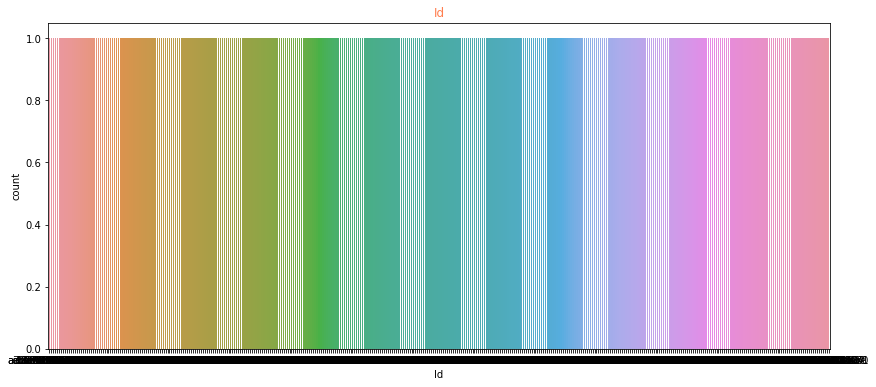

In [706]:
plt.figure(figsize = (14, 6))
sns.countplot(df['Id'])
plt.title('Id',color='coral')
print(df['Id'].unique())
print('\t')
print('****************************')
print()
print(df['Id'].value_counts())
print()

### Pie-Chart

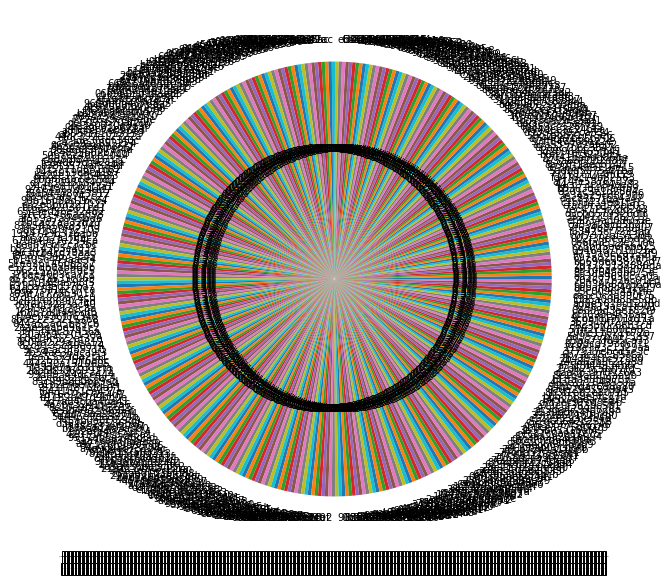

In [707]:
plt.figure(figsize=(10,10))
df.Id.value_counts().plot(kind='pie', autopct='%1.1f%%', table = True)
plt.show()

## groupId

### Count Plot

['648f284d7dd1a6' '07105fa566e9ca' 'fd7a0f9cbbbc69' 'ed1c97ef4aaac8'
 'f821dae08776cb' 'ffba4229bc4af4' 'a34a384937e2e9' 'f29aaa945d401e'
 'cd7cdcd7190f50' 'bb7ce416907ac1' '6d55bfbd8801eb' '521be34a85780d'
 'b32bc917f22ca2' '601bc2ff25389c' '46f069c11efed1' 'ebbd9adf9a8b4b'
 '0f402f7f062f6c' '9a2aadf5638493' 'ed43ed585dd2e7' '36d9709b982ec4'
 'b32de1ede98766' '191f283260a348' 'a49818916346c1' 'f039d1bf1e818b'
 'e3bacbca4535fe' 'd44da8e0e5faaa' '8092d53add420a' 'c9dd427bcbed3e'
 'c273e00b6a2135' '2ee643cd6e7199' 'a63c6c55d1dbdf' 'e33c475487dbc4'
 '3460413e2f13c5' '39ab711fffe959' 'ab0ec4fd4817d3' 'ebe05c235cc94c'
 '3ec9190c5cca9f' 'e95146ee72b0b8' '18ef233dce5e29' 'c569977a7325cc'
 'de589eb67787e7' 'e0ccc25e34f9b9' '7700bccbb10b51' 'a862550184ed88'
 '831af605a4dfe7' '0a3f770eba44a2' 'f1b8460bf878e9' 'f040d8a3c48948'
 '5ca13750cb2f76' '6779a3ee3db89a' '50d1c8ef891c8d' 'd77bb45475eef4'
 '4d6794147882db' 'fb69cf66fb2a9e' 'abd215388e5e3a' '9ada482cab8c4c'
 '05af1015b55132' '9c859e53d78769'

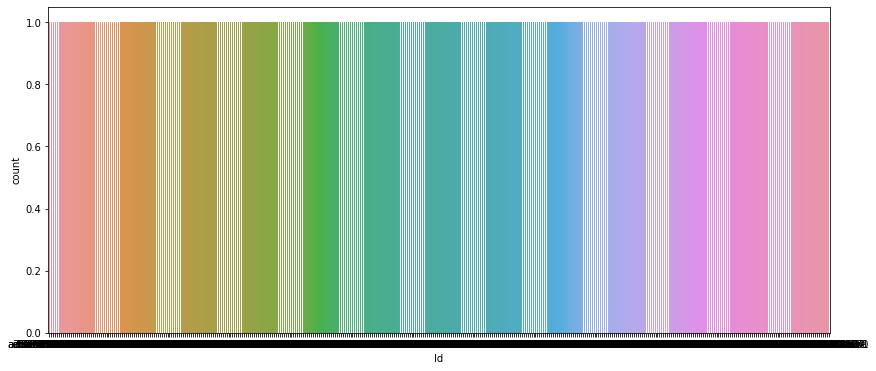

In [708]:
plt.figure(figsize = (14, 6))
sns.countplot(df['Id'])
print(df['groupId'].unique())
print('\t')
print('****************************')
print()
print(df['groupId'].value_counts())
print()
print(len(df['groupId'].value_counts()))

### Pie-Chart

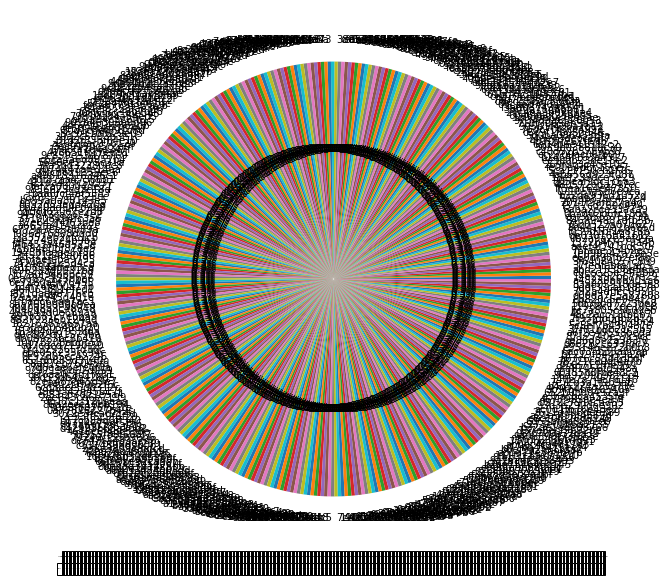

In [709]:
plt.figure(figsize=(10,10))
df.groupId.value_counts().plot(kind='pie', autopct='%1.1f%%', table = True)
plt.show()

## matchId

### Count Plot

In [710]:
plt.figure(figsize = (14, 6))
sns.countplot(df['matchId'])
plt.title('matchId',color='coral')
print(df['matchId'].unique())
print('\t')
print('****************************')
print()
print(df['matchId'].value_counts())
print()

['2e74fc24bc1bc8' '20315d1baba1b6' 'f3a3dde6dae261' '45114f703dbd2a'
 '9733c783a5ee59' 'c26bc06a68a487' 'b28b84527ede41' '242149c095e56a'
 '16562bc04501d5' '4f1c28c90191a3' '94db2edfe39537' 'e39c3bcd5391f5'
 '654dcf5711575a' '684e07f3b9d9a9' '6d94e7f7636767' 'e680bd863add4f'
 '512b4c93fa50b3' '90afcbf2f321d0' 'd312ec193b0b4d' '2b068097791374'
 '85ee2630a65a33' '270e3a59ae4d1c' '1f442ca14d8de9' '08eaffd1aed5af'
 '132e8f7a48e744' '03a2a1048034d3' '5e76db3f398aa6' 'df779d109ee26d'
 '04e4a530ba248b' 'e504153ba09640' 'd6febefa14b878' '129316b3c00773'
 'c90734b10105d1' '5bf7cd41481aff' '6e1178a6ef4973' 'd26b3a0ae3d3ba'
 'fa54dcef0ffc1b' 'a48472ef4489c4' '66f3ad371e80db' '9f7692d9eb282d'
 'a8c4a57a5ee6a4' '1b5c8f9c0a2ee4' '1b4e706b2e6edc' 'a56905b2242156'
 '2038f1b36e30c4' '6ce02b788feeb6' '4052f43358b98b' '7ca7c4bd59d23b'
 '7c9ba5f5267e54' 'b2cf90ae91c12c' 'd67e3a39efb615' '4287076544ee59'
 '7a07f9b5355d2c' '41bc23bb0ea0f8' '1ff7d454522dc5' '8ce74a5bf38233'
 '48dbfec5dd022d' '40616f518eac1c'

### Pie-Chart

In [711]:
plt.figure(figsize=(10,10))
df.matchId.value_counts().plot(kind='pie', autopct='%1.1f%%', table = True)
plt.show()

## matchType

### Count Plot

In [712]:
plt.figure(figsize = (14, 6))
sns.countplot(df['matchType'])
plt.title('matchType',color='coral')
print(df['matchType'].unique())
print('\t')
print('****************************')
print()
print(df['matchType'].value_counts())
print()

['duo-fpp' 'squad-fpp' 'duo' 'solo' 'squad' 'solo-fpp' 'normal-squad-fpp'
 'crashfpp']
	
****************************

squad-fpp           162
duo-fpp              86
squad                44
solo-fpp             41
duo                  36
solo                 22
normal-squad-fpp      3
crashfpp              3
Name: matchType, dtype: int64



### Pie-Chart

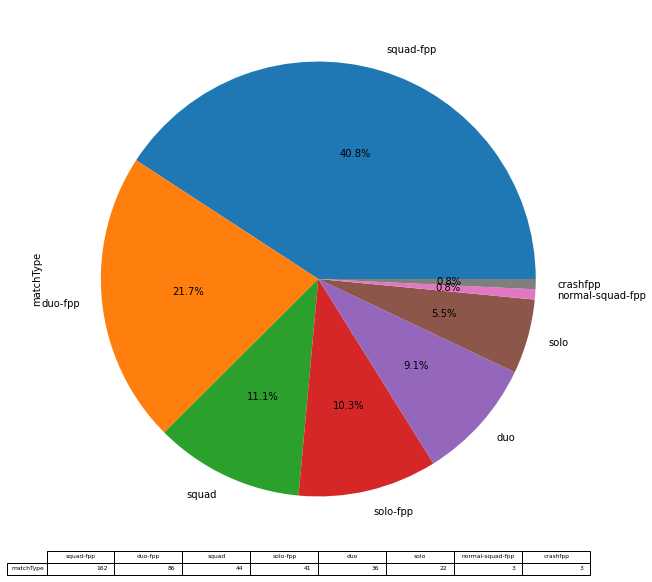

In [713]:
plt.figure(figsize=(10,10))
df.matchType.value_counts().plot(kind='pie', autopct='%1.1f%%', table = True)
plt.show()

# New Section

## Unnamed

### Count Plot

In [714]:
df=df.rename(columns = {'Unnamed: 0':'Unnamed'})

In [715]:
plt.figure(figsize=(20,8))
sns.countplot(df['Unnamed'])
plt.title('Unnamed',color='coral')
print(df['Unnamed'].unique())
print()
print('****************************')
print()
print(df['Unnamed'].value_counts())
print()

[4373037 1129914 4012906 4322850 3365734 2384421 2348970 1444846  773559
 3539034 3146529 2502432   54576 3100115 3978914 1864076 3110304 1001438
 2487814 1448990 2839218  246958 3463758 3337479 1426884  478668 2383264
 1531678 2631566 3585917   44119  974428 1572589 2438566 3755408 4426815
  829590 1625150  101021 1267176 3644313 1878798 1545004 2591473 2125435
 3568678 1993506 3240526  522752 1788813 2170624 1449592 1528718 4277737
  107655 3411570  181811  486041 1818330  469107 1057274 1344625 2775392
  191423 2997883 1392952 3615491  423968 3401234 4038795 2918100 3524508
  907804 3340680  245814 2873218 3229819 2899902  884903 4398944  266355
 3752995 1629063 4225766  158476 2044175 1206172 2027474 3638687 1355249
 1524598 3691649  419388 3028675  630688 2347276 1534878  551580 2340524
 1122733 3278703 2324778 3721900 2781683 1796947 1373047 3057984 3978804
  973955 2138090  983113 2052975  685347 1980532 2058884 2683357  295316
 2480882 1716163  187507 4237586 2837855 1443628 34

### Pie-Chart

In [716]:
plt.figure(figsize=(10,10))
df.Unnamed.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

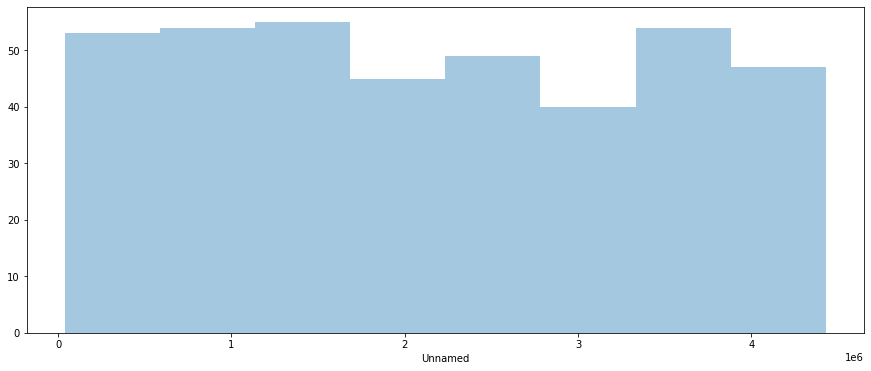

In [717]:
plt.figure(figsize=(15,6))
sns.distplot(df['Unnamed'],kde=False)
plt.show()


### Normal Distribution

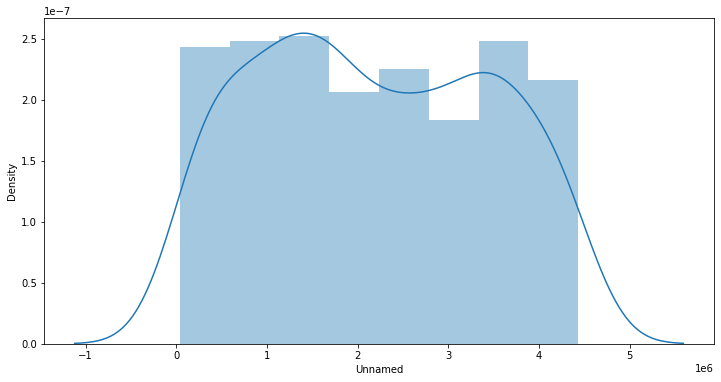


mean:  2173559.539042821
median: 2058884.0
mode: 0        39406
1        43896
2        44119
3        52280
4        54576
        ...   
392    4398944
393    4405099
394    4416021
395    4426815
396    4429938
Length: 397, dtype: int64

Skewness: 0.08688349405133795
Kurtosis: -1.1967214510658661



In [718]:
plt.figure(figsize=(12,6))
sns.distplot(df['Unnamed'])
plt.show()
print()
print('mean: ',df['Unnamed'].mean())
print('median:',df['Unnamed'].median())
print('mode:',df['Unnamed'].mode())
print()
print('Skewness:',skew(df['Unnamed']))
print('Kurtosis:',kurtosis(df['Unnamed']))
print()

**Observation:** 

*   Its looks like  Uniform Distribution



### Box-Cox Transformation

In [719]:
plt.figure(figsize=(12,6))
transformed, _ = stats.boxcox(df['Unnamed']) 
#plot the distribution of the transformed data values
sns.distplot(transformed)
plt.show()
'''print()
print()
print('mean: ',transformed.mean())
print('median:',np.median(transformed))
print('mode:',st.mode(transformed))
print()
print('Skewness:',skew(transformed))
print('Kurtosis:',kurtosis(transformed))
print()'''

"print()\nprint()\nprint('mean: ',transformed.mean())\nprint('median:',np.median(transformed))\nprint('mode:',st.mode(transformed))\nprint()\nprint('Skewness:',skew(transformed))\nprint('Kurtosis:',kurtosis(transformed))\nprint()"

**Observation:** 
*   After applying Box-Cox Transformation Graph becomes **Zero-skewed**
*   we can check this by using mean,mode and median. here mean, mode and median are almost same.



### Box Plot

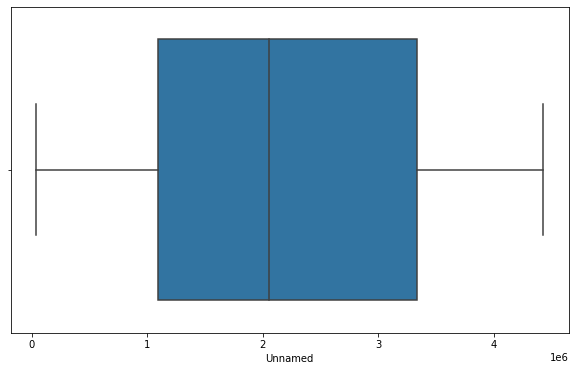

In [720]:
plt.figure(figsize=(10,6))
sns.boxplot(df['Unnamed'])

**Observation:** There are no outliers present in Unnamed

In [721]:
df.isnull().sum()

Unnamed            0
Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

## assists

### Count Plot

[0. 1. 2. 3.]

****************************

0.0    326
1.0     61
2.0      8
3.0      2
Name: assists, dtype: int64



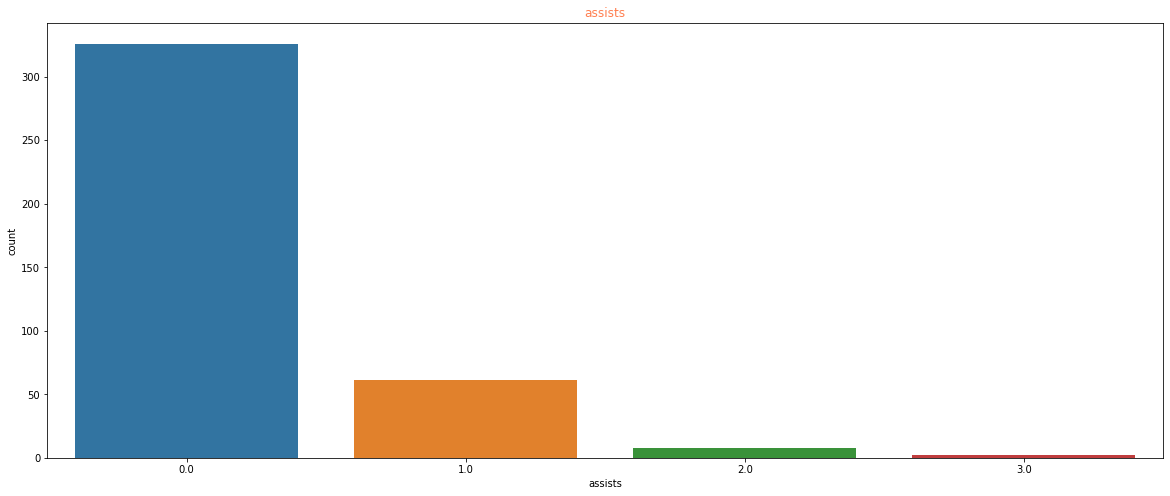

In [722]:
plt.figure(figsize=(20,8))
sns.countplot(df['assists'])
plt.title('assists',color='coral')
print(df['assists'].unique())
print()
print('****************************')
print()
print(df['assists'].value_counts())
print()

### Pie-Chart

In [723]:
plt.figure(figsize=(10,10))
df.assists.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

In [724]:
plt.figure(figsize=(15,6))
sns.distplot(df['assists'],kde=False)
plt.show()


**Observation:** Most of the values are present in 0th position. so we can treat them others as outliers

### Normal Distribution

In [725]:
plt.figure(figsize=(12,6))
sns.distplot(df['assists'])
plt.show()
print()
print('mean: ',df['assists'].mean())
print('median:',df['assists'].median())
print('mode:',df['assists'].mode())
print()
print('Skewness:',skew(df['assists']))
print('Kurtosis:',kurtosis(df['assists']))
print()


mean:  0.20906801007556675
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 2.5643956843924407
Kurtosis: 7.327742756906149



**Observation:** 

*   The above graph is Positively Skewed normal Distribution. It has very Long tail
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

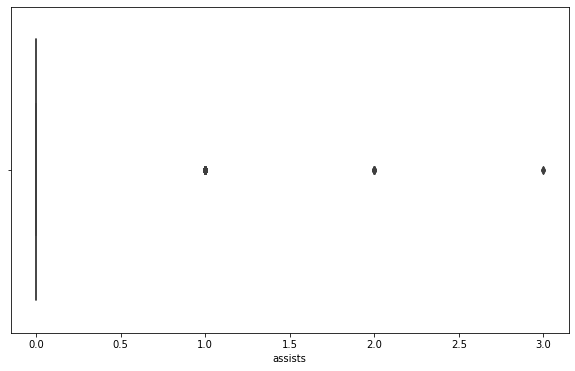

In [726]:
plt.figure(figsize=(10,6))
sns.boxplot(df['assists'])

**Observation:** Most of the values present at 0th position. so median is **Zero** remaining points are **Outliers**.

## boosts

### Count Plot

In [727]:
plt.figure(figsize=(20,8))
sns.countplot(df['boosts'])
plt.title('boosts',color='coral')
print(df['boosts'].unique())
print()
print('****************************')
print()
print(df['boosts'].value_counts())
print()

[ 1.  3.  0.  2.  7.  4.  6.  8.  5. 10. 11.]

****************************

0.0     209
1.0      75
2.0      34
3.0      32
4.0      16
5.0      10
6.0       9
7.0       6
8.0       4
11.0      1
10.0      1
Name: boosts, dtype: int64



### Pie-Chart

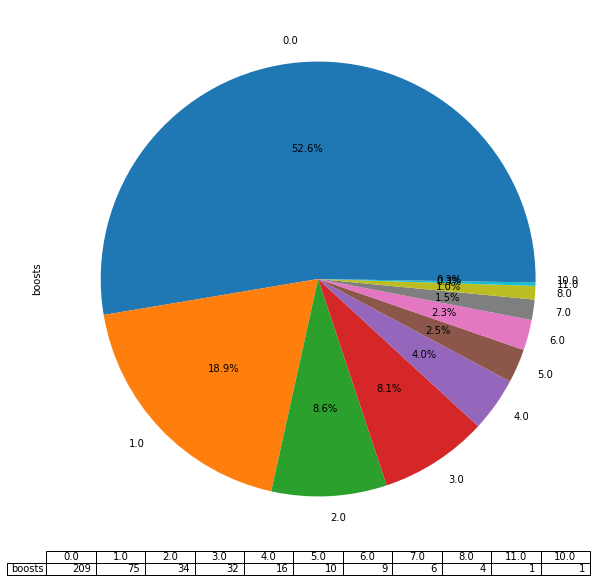

In [728]:
plt.figure(figsize=(10,10))
df.boosts.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

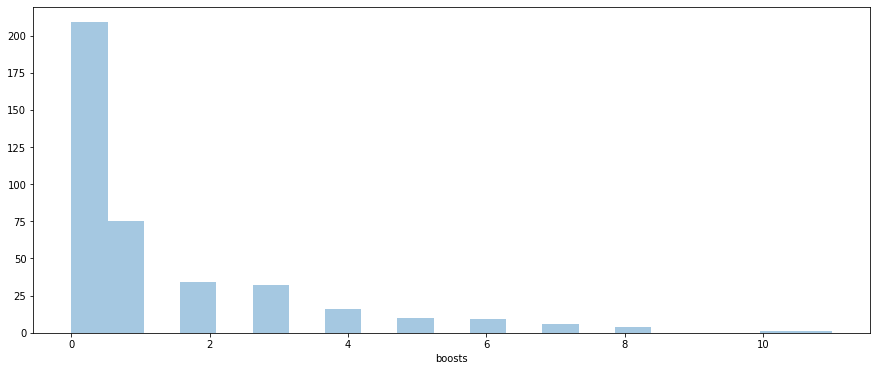

In [729]:
plt.figure(figsize=(15,6))
sns.distplot(df['boosts'],kde=False)
plt.show()


### Normal Distribution

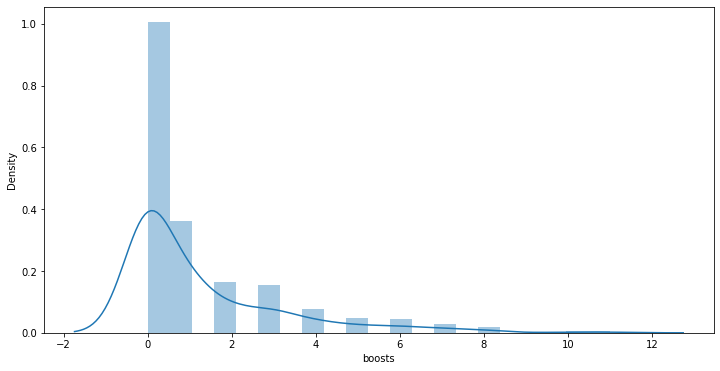


mean:  1.2644836272040303
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 1.9556879463162002
Kurtosis: 3.9780843451405596



In [730]:
plt.figure(figsize=(12,6))
sns.distplot(df['boosts'])
plt.show()
print()
print('mean: ',df['boosts'].mean())
print('median:',df['boosts'].median())
print('mode:',df['boosts'].mode())
print()
print('Skewness:',skew(df['boosts']))
print('Kurtosis:',kurtosis(df['boosts']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

In [731]:
plt.figure(figsize=(10,6))
sns.boxplot(df['boosts'])

**Observation:** There are exactly 3 outliers are present.

## damageDealt

### Count Plot

In [732]:
plt.figure(figsize=(20,8))
sns.countplot(df['damageDealt'])
plt.title('damageDealt',color='coral')
print(df['damageDealt'].unique())
print()
print('****************************')
print()
print(df['damageDealt'].value_counts())
print()

[4.675e+01 3.828e+02 2.989e+02 9.065e+01 0.000e+00 3.430e+01 1.344e+02
 1.563e+02 9.828e+01 3.573e+02 5.780e+01 2.000e+02 8.172e+02 4.410e+02
 4.085e+01 1.440e+02 1.778e+02 9.490e+01 8.026e+01 2.139e+02 2.131e+01
 6.090e+01 1.772e+02 1.281e+03 2.511e+01 4.644e+01 1.288e+02 3.792e+01
 2.940e+01 9.126e+01 1.000e+02 1.679e+02 1.194e+02 2.867e+02 4.212e+02
 1.186e+02 6.015e+01 1.029e+02 9.211e+01 5.063e+01 3.010e+01 1.120e+02
 5.235e+01 3.002e+01 1.750e+02 8.600e+01 9.628e+01 3.436e+02 5.713e+01
 1.468e+02 1.622e+02 1.240e+02 6.955e+02 1.872e+01 6.570e+02 7.592e+01
 1.228e+02 3.060e+02 1.536e+02 6.987e+01 1.222e+02 1.178e+02 9.030e+02
 1.417e+02 1.592e+02 1.357e+02 2.524e+01 1.442e+02 3.000e+02 4.000e+02
 1.169e+02 6.063e+01 2.299e+02 8.840e+01 3.754e+02 4.290e+01 2.340e+01
 2.875e+02 2.225e+02 5.390e+01 1.450e+02 3.541e+02 3.299e+02 5.445e+01
 2.994e+01 1.403e+02 2.121e+02 1.735e+02 3.360e+02 3.294e+01 2.351e+02
 2.034e+02 2.646e+01 2.831e+02 1.371e+02 1.139e+02 1.488e+02 1.996e+02
 1.581

### Pie-Chart

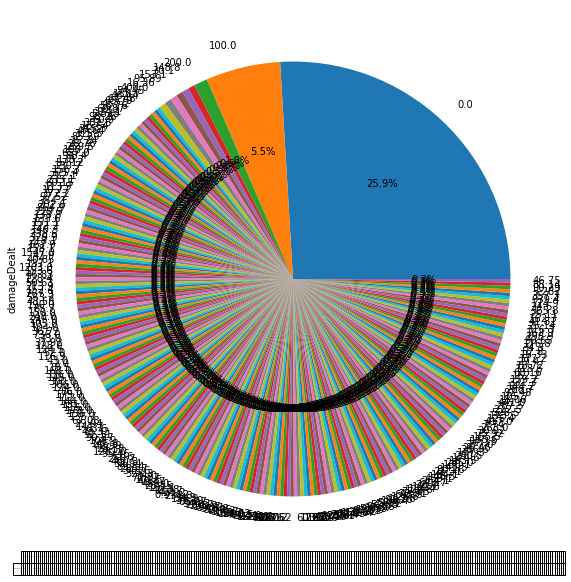

In [733]:
plt.figure(figsize=(10,10))
df.damageDealt.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

In [734]:
plt.figure(figsize=(15,6))
sns.distplot(df['damageDealt'],kde=False)
plt.show()


### Normal Distribution

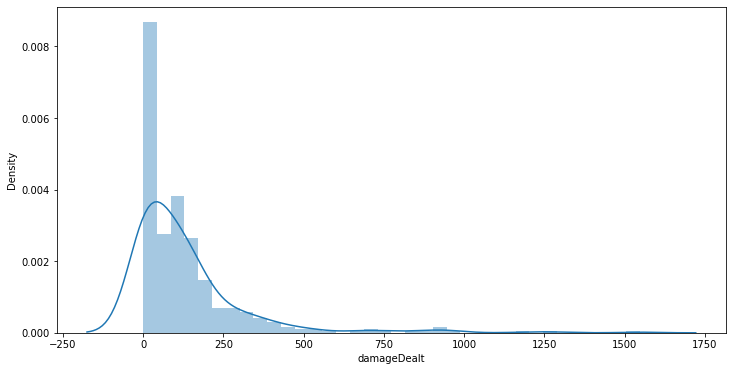


mean:  132.31026750629718
median: 89.54
mode: 0    0.0
dtype: float64

Skewness: 3.3653352360258277
Kurtosis: 15.251882629535672



In [735]:
plt.figure(figsize=(12,6))
sns.distplot(df['damageDealt'])
plt.show()
print()
print('mean: ',df['damageDealt'].mean())
print('median:',df['damageDealt'].median())
print('mode:',df['damageDealt'].mode())
print()
print('Skewness:',skew(df['damageDealt']))
print('Kurtosis:',kurtosis(df['damageDealt']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

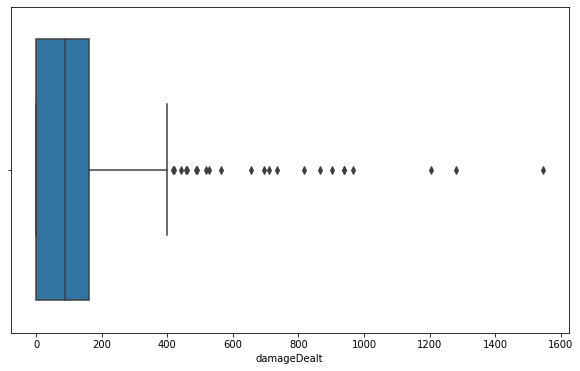

In [736]:
plt.figure(figsize=(10,6))
sns.boxplot(df['damageDealt'])

**Observation:** There are lot of outliers. This outliers are one responsible for not getting normal distribution.

### Removing Outliers

In [737]:
damageDealt_outliers=i_q_r(df['damageDealt'])
print(damageDealt_outliers[0])
print(damageDealt_outliers[1])


Lower limit is:  -242.54999999999998
Upper limit is:  404.25
-242.54999999999998
404.25


## DBNOs

### Count Plot

[0. 3. 2. 1. 9. 4. 5. 6. 7.]

****************************

0.0    247
1.0     97
2.0     29
3.0     11
4.0      6
5.0      3
6.0      2
7.0      1
9.0      1
Name: DBNOs, dtype: int64



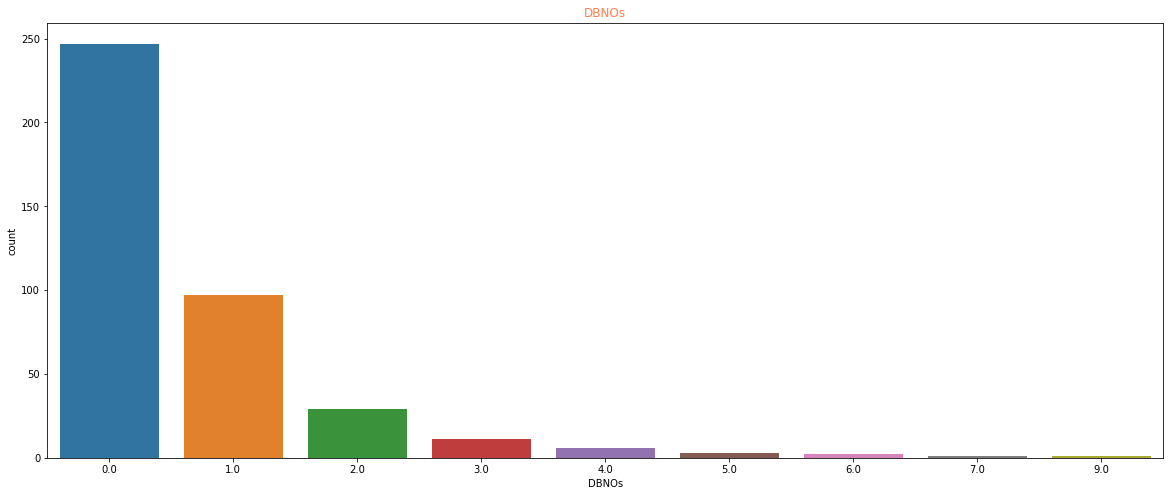

In [738]:
plt.figure(figsize=(20,8))
sns.countplot(df['DBNOs'])
plt.title('DBNOs',color='coral')
print(df['DBNOs'].unique())
print()
print('****************************')
print()
print(df['DBNOs'].value_counts())
print()

### Pie-Chart

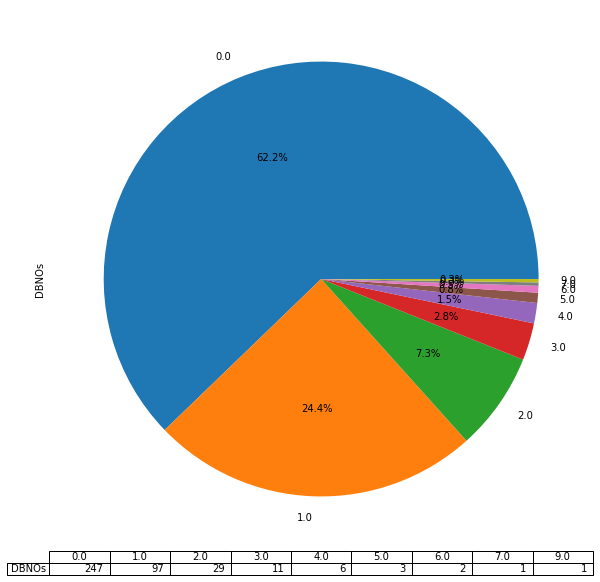

In [739]:
plt.figure(figsize=(10,10))
df.DBNOs.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

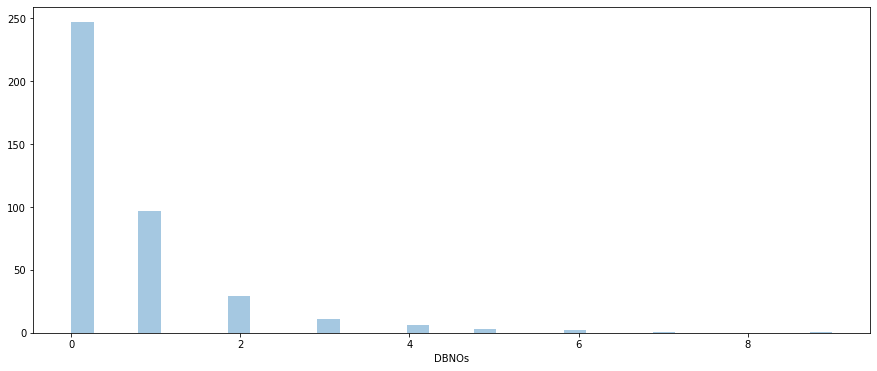

In [740]:
plt.figure(figsize=(15,6))
sns.distplot(df['DBNOs'],kde=False)
plt.show()


### Normal Distribution

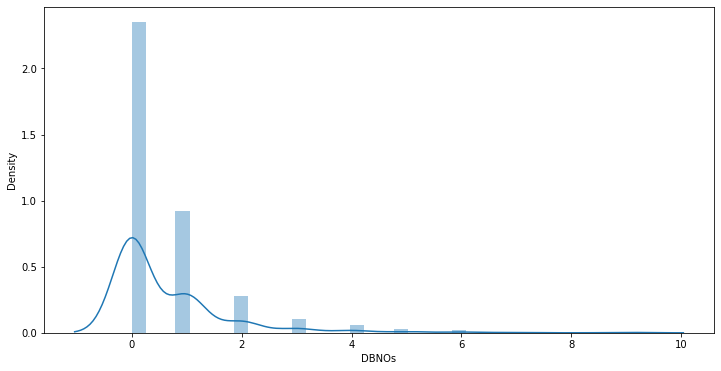


mean:  0.6423173803526449
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 2.979634056498728
Kurtosis: 12.326085160670642



In [741]:
plt.figure(figsize=(12,6))
sns.distplot(df['DBNOs'])
plt.show()
print()
print('mean: ',df['DBNOs'].mean())
print('median:',df['DBNOs'].median())
print('mode:',df['DBNOs'].mode())
print()
print('Skewness:',skew(df['DBNOs']))
print('Kurtosis:',kurtosis(df['DBNOs']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

In [742]:
plt.figure(figsize=(10,6))
sns.boxplot(df['DBNOs'])

**Observation:** There are exactly 5 outliers are present in this column. This outliers are one responsible for not getting normal distribution.

### Removing Outliers

In [743]:
DBNOs_outliers=i_q_r(df['DBNOs'])
print(DBNOs_outliers[0])
print(DBNOs_outliers[1])


Lower limit is:  -1.5
Upper limit is:  2.5
-1.5
2.5


In [744]:
df.head()

Unnamed              Id  ... winPoints winPlacePerc
27893  4373037  a79e0f363bc581  ...    1507.0       0.5918
11506  1129914  aadee1d4e20be0  ...       0.0       0.4667
43474  4012906  c301f72d0fe714  ...    1495.0       0.7826
40609  4322850  ebe51b88e978b8  ...       0.0       0.0851
35047  3365734  daa61093629f64  ...    1487.0       0.4286

[5 rows x 30 columns]

## headshotKills

### Count Plot

[0. 1. 2. 4. 3.]

****************************

0.0    329
1.0     52
2.0     10
3.0      3
4.0      3
Name: headshotKills, dtype: int64



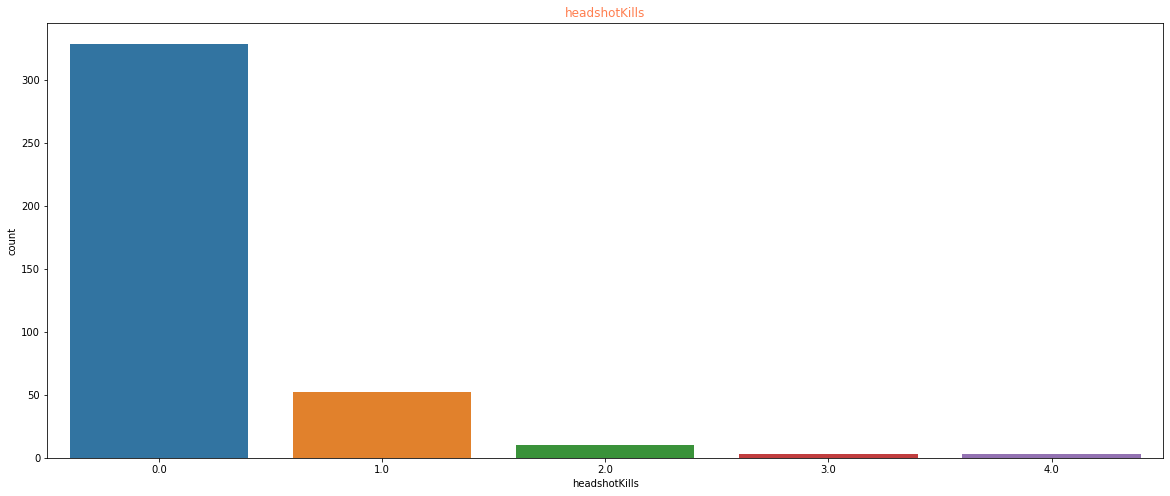

In [745]:
plt.figure(figsize=(20,8))
sns.countplot(df['headshotKills'])
plt.title('headshotKills',color='coral')
print(df['headshotKills'].unique())
print()
print('****************************')
print()
print(df['headshotKills'].value_counts())
print()

### Pie-Chart

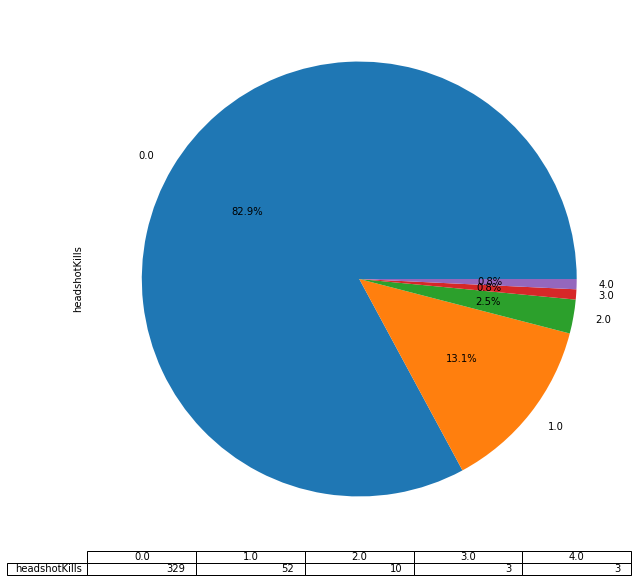

In [746]:
plt.figure(figsize=(10,10))
df.headshotKills.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

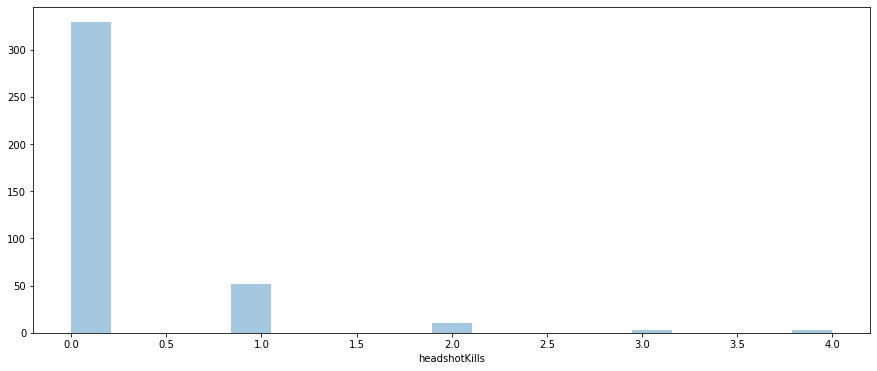

In [747]:
plt.figure(figsize=(15,6))
sns.distplot(df['headshotKills'],kde=False)
plt.show()


### Normal Distribution

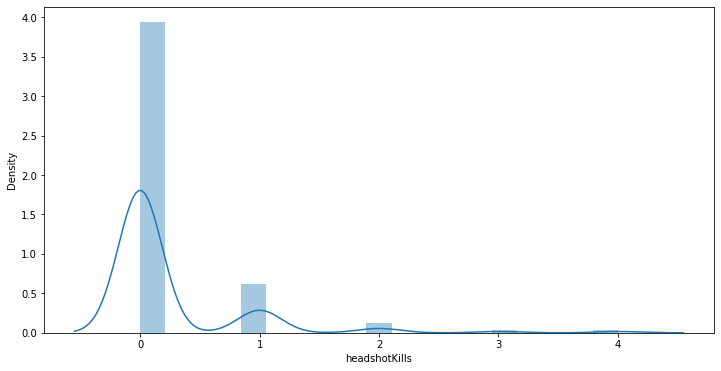


mean:  0.23425692695214106
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 3.391339745303792
Kurtosis: 13.848024390387014



In [748]:
plt.figure(figsize=(12,6))
sns.distplot(df['headshotKills'])
plt.show()
print()
print('mean: ',df['headshotKills'].mean())
print('median:',df['headshotKills'].median())
print('mode:',df['headshotKills'].mode())
print()
print('Skewness:',skew(df['headshotKills']))
print('Kurtosis:',kurtosis(df['headshotKills']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

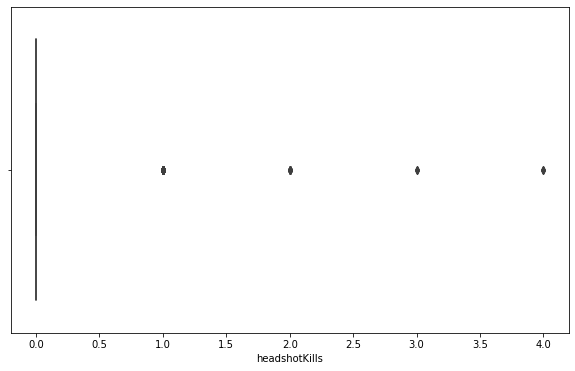

In [749]:
plt.figure(figsize=(10,6))
sns.boxplot(df['headshotKills'])

**Observation:** Very less people are died with head shots and theseo people are treated as Outliers

## heals

### Count Plot

[ 0.  2.  3.  1.  4.  5. 11.  7. 10.  6.  8. 20. 14. 12. 19.  9.]

****************************

0.0     230
1.0      62
2.0      30
3.0      16
5.0      15
4.0      10
8.0       9
6.0       7
7.0       7
11.0      3
12.0      2
14.0      2
9.0       1
19.0      1
20.0      1
10.0      1
Name: heals, dtype: int64



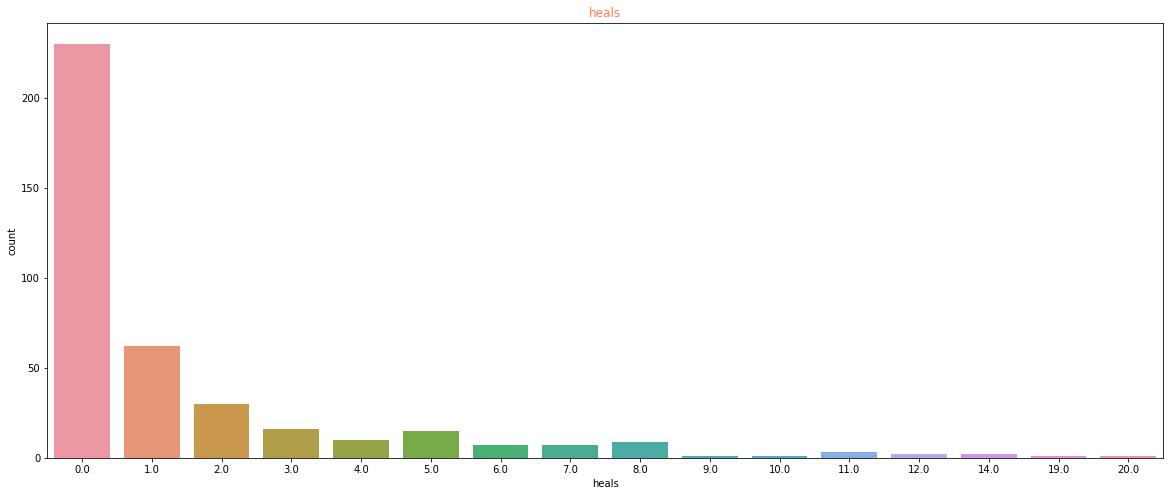

In [750]:
plt.figure(figsize=(20,8))
sns.countplot(df['heals'])
plt.title('heals',color='coral')
print(df['heals'].unique())
print()
print('****************************')
print()
print(df['heals'].value_counts())
print()

### Pie-Chart

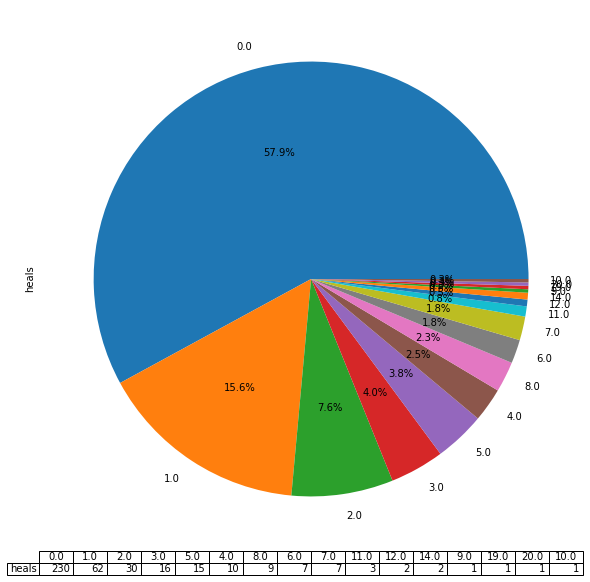

In [751]:
plt.figure(figsize=(10,10))
df.heals.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

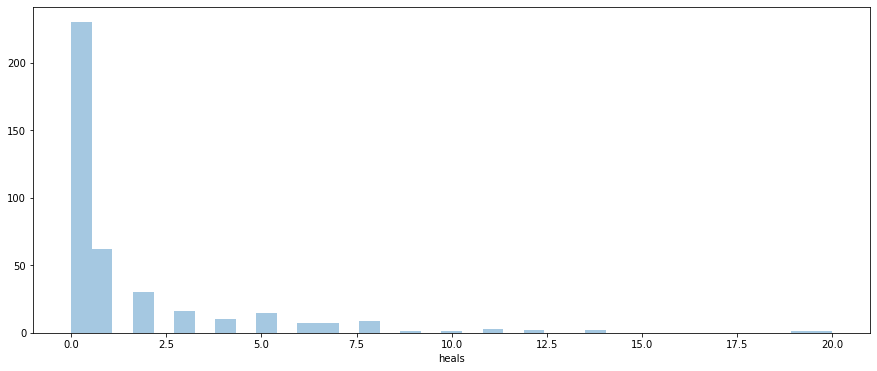

In [752]:
plt.figure(figsize=(15,6))
sns.distplot(df['heals'],kde=False)
plt.show()


### Normal Distribution

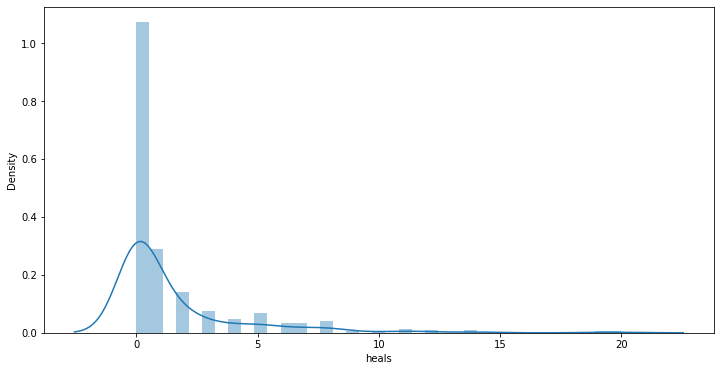


mean:  1.4886649874055415
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 2.9453050917568673
Kurtosis: 11.00876996923186



In [753]:
plt.figure(figsize=(12,6))
sns.distplot(df['heals'])
plt.show()
print()
print('mean: ',df['heals'].mean())
print('median:',df['heals'].median())
print('mode:',df['heals'].mode())
print()
print('Skewness:',skew(df['heals']))
print('Kurtosis:',kurtosis(df['heals']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

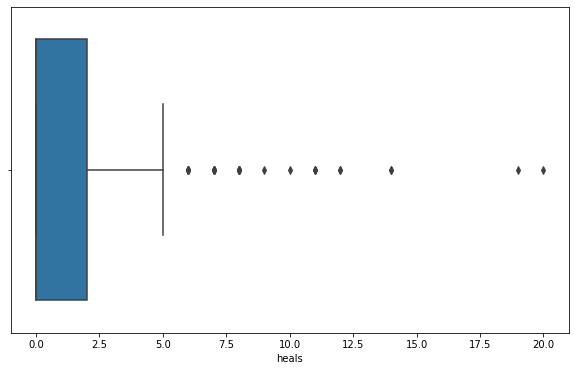

In [754]:
plt.figure(figsize=(10,6))
sns.boxplot(df['heals'])

**Observation:** Very less people are getting high healing. So they treated as outliers

## killPlace

### Count Plot

In [755]:
plt.figure(figsize=(20,8))
sns.countplot(df['killPlace'])
plt.title('killPlace',color='coral')
print(df['killPlace'].unique())
print()
print('****************************')
print()
print(df['killPlace'].value_counts())
print()

[60.  4. 27. 85. 64. 44. 90. 88. 17. 38. 78. 66.  8. 73. 61. 14.  1.  5.
 71. 67. 41. 30. 39. 83. 54. 42. 55. 81. 35. 94. 93. 47. 59. 56. 22. 86.
 40. 10. 52. 63. 48. 19. 43. 11. 95. 74. 84. 72. 25. 49. 20. 79.  7. 69.
 29.  6. 82. 65. 37. 28. 68. 12. 58. 21.  2. 23. 31. 77. 36. 46. 70. 80.
 51. 98. 32. 76. 45.  9. 62. 26. 53. 50.  3. 13. 15. 89. 97. 87. 96. 18.
 33. 91. 75. 92. 34. 57.]

****************************

49.0    9
65.0    9
22.0    8
14.0    8
1.0     8
       ..
66.0    1
87.0    1
97.0    1
3.0     1
57.0    1
Name: killPlace, Length: 96, dtype: int64



### Pie-Chart

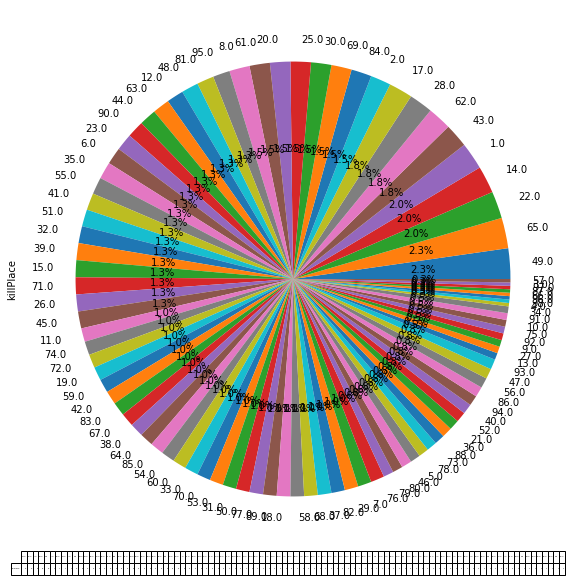

In [756]:
plt.figure(figsize=(10,10))
df.killPlace.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

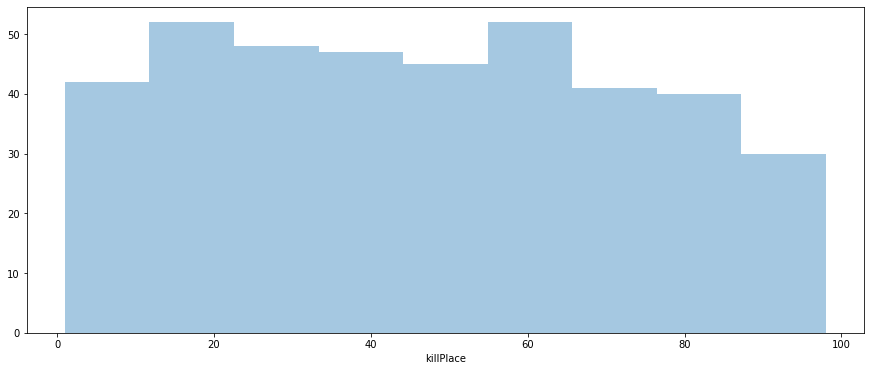

In [757]:
plt.figure(figsize=(15,6))
sns.distplot(df['killPlace'],kde=False)
plt.show()


### Normal Distribution

In [758]:
plt.figure(figsize=(12,6))
sns.distplot(df['killPlace'])
plt.show()
print()
print('mean: ',df['killPlace'].mean())
print('median:',df['killPlace'].median())
print('mode:',df['killPlace'].mode())
print()
print('Skewness:',skew(df['killPlace']))
print('Kurtosis:',kurtosis(df['killPlace']))
print()


mean:  47.05793450881612
median: 47.0
mode: 0    49.0
1    65.0
dtype: float64

Skewness: 0.047613637512572096
Kurtosis: -1.1113871749325577



**Observation:** 

*   The above graph looks like Uniform Distribution


### Box-Cox Transformation

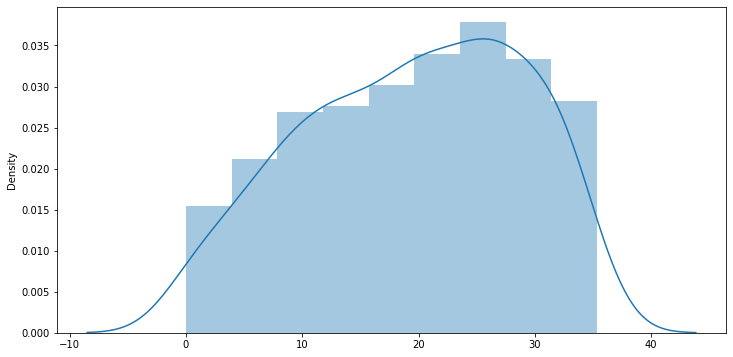



mean:  19.49279228111024
median: 20.375848403525424

Skewness: -0.25804568428178903
Kurtosis: -0.9335386741647644



In [759]:
plt.figure(figsize=(12,6))
transformed, _ = stats.boxcox(df['killPlace']) 
#plot the distribution of the transformed data values
sns.distplot(transformed)
plt.show()
print()
print()
print('mean: ',transformed.mean())
print('median:',np.median(transformed))
'''print('mode:',st.mode(transformed))'''
print()
print('Skewness:',skew(transformed))
print('Kurtosis:',kurtosis(transformed))
print()

**Observation:** 
*   After applying Box-Cox Transformation kurtosis is reduced




### Box Plot

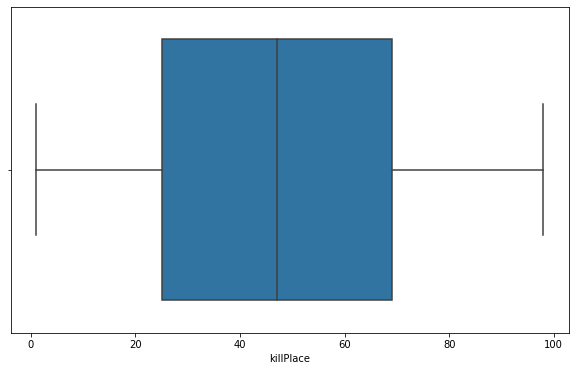

In [760]:
plt.figure(figsize=(10,6))
sns.boxplot(df['killPlace'])

**Observation:** There are no  outliers present in this graph as it follows Uniform Distribution.

## killPoints

### Count Plot

[1347.    0. 1070. 1101. 1043. 1124. 1012. 1045. 1325. 1119. 1063. 1315.
 1144. 1126. 1251. 1076. 1000. 1256. 1210. 1297. 1088. 1033.  998. 1506.
 1135. 1158. 1237. 1125. 1155. 1110. 1408. 1218. 1113. 1362. 1379. 1034.
 1498. 1470. 1243. 1108. 1194. 1568. 1208. 1090. 1600. 1170. 1044. 1209.
 1260. 1390. 1423. 1696. 1363. 1025. 1293. 1580. 1433. 1495. 1096. 1515.
 1535. 1172. 1392. 1331. 1129. 1352. 1321. 1422. 1684. 1339. 1016. 1455.
 1416. 1341. 1428. 1343. 1198. 1311. 1391.  960. 1067. 1310. 1319. 1487.
 1099. 1232. 1038. 1749. 1117. 1333.  991. 1437. 1458. 1148. 1176. 1475.
 1235. 1505. 1065. 1307. 1244. 1350. 1187. 1471. 1231. 1689. 1840. 1399.
 1368. 1216. 1091. 1851. 1526. 1372. 1322. 1202. 1134. 1047. 1245. 1503.
 1160. 1280. 1420. 1163.  974. 1139. 1448.  995. 1326. 1250. 1177. 1133.
 1082. 1386. 1254. 1305. 1017. 1029. 1015. 1627.]

****************************

0.0       229
1000.0     14
1580.0      2
1045.0      2
998.0       2
         ... 
1135.0      1
1113.0      1
1243

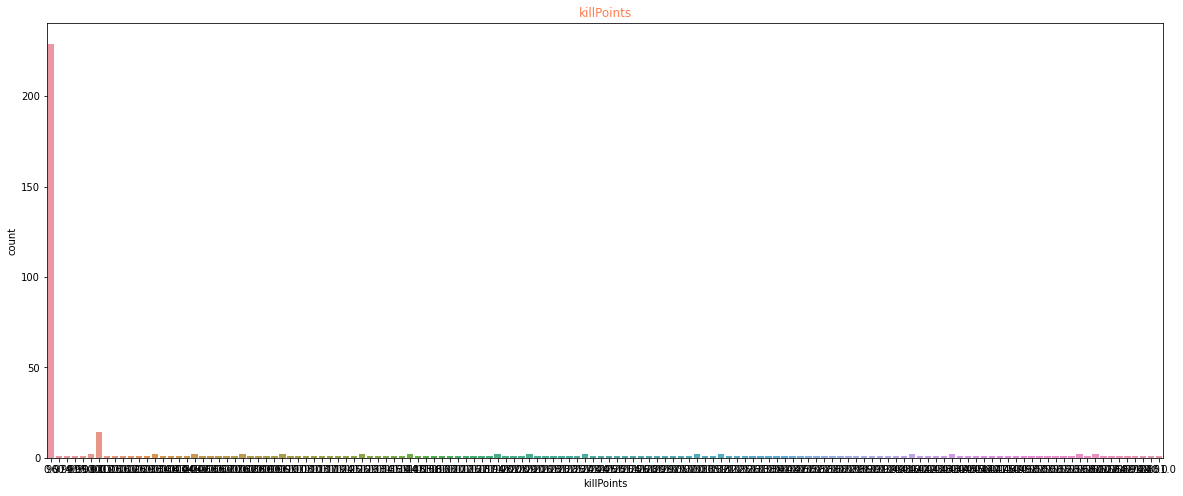

In [761]:
plt.figure(figsize=(20,8))
sns.countplot(df['killPoints'])
plt.title('killPoints',color='coral')
print(df['killPoints'].unique())
print()
print('****************************')
print()
print(df['killPoints'].value_counts())
print()

### Pie-Chart

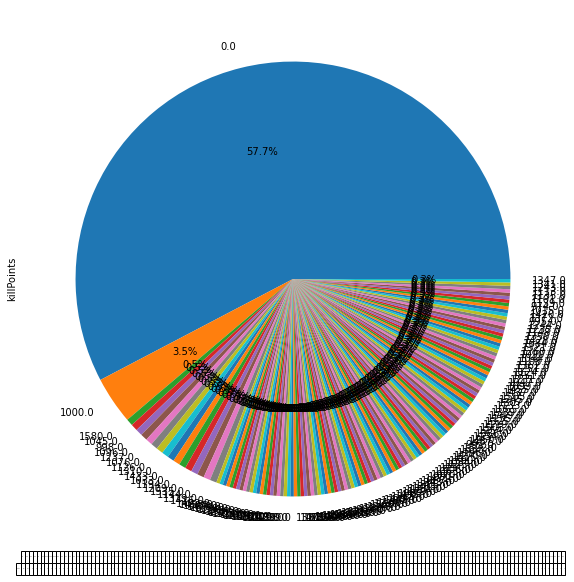

In [762]:
plt.figure(figsize=(10,10))
df.killPoints.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

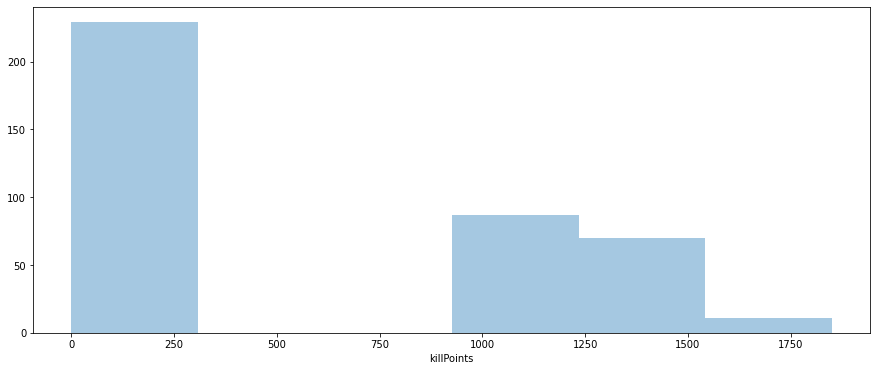

In [763]:
plt.figure(figsize=(15,6))
sns.distplot(df['killPoints'],kde=False)
plt.show()


### Normal Distribution

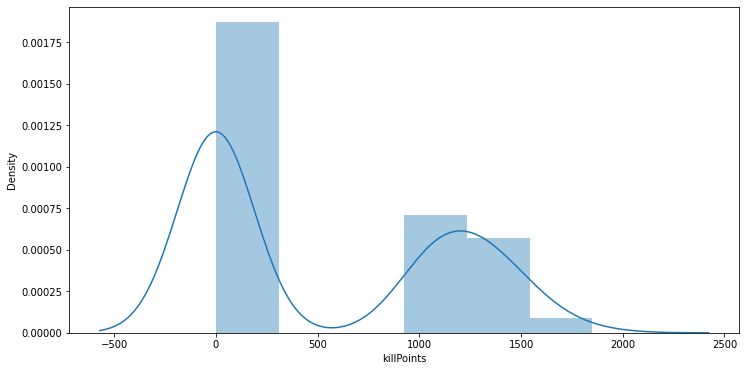


mean:  527.095717884131
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 0.440746988441203
Kurtosis: -1.620723661931925



In [764]:
plt.figure(figsize=(12,6))
sns.distplot(df['killPoints'])
plt.show()
print()
print('mean: ',df['killPoints'].mean())
print('median:',df['killPoints'].median())
print('mode:',df['killPoints'].mode())
print()
print('Skewness:',skew(df['killPoints']))
print('Kurtosis:',kurtosis(df['killPoints']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

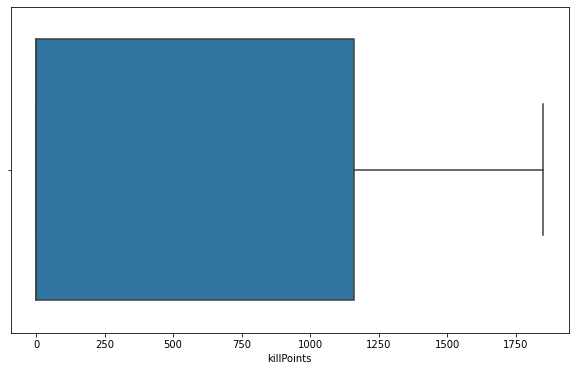

In [765]:
plt.figure(figsize=(10,6))
sns.boxplot(df['killPoints'])

**Observation:** There are no  outliers present in this graph.

## kills

### Count Plot

[ 0.  5.  1.  2.  3.  7.  4. 10.  8.  6. 11.]

****************************

0.0     227
1.0      87
2.0      39
3.0      17
4.0       9
5.0       5
6.0       4
10.0      3
11.0      2
8.0       2
7.0       2
Name: kills, dtype: int64



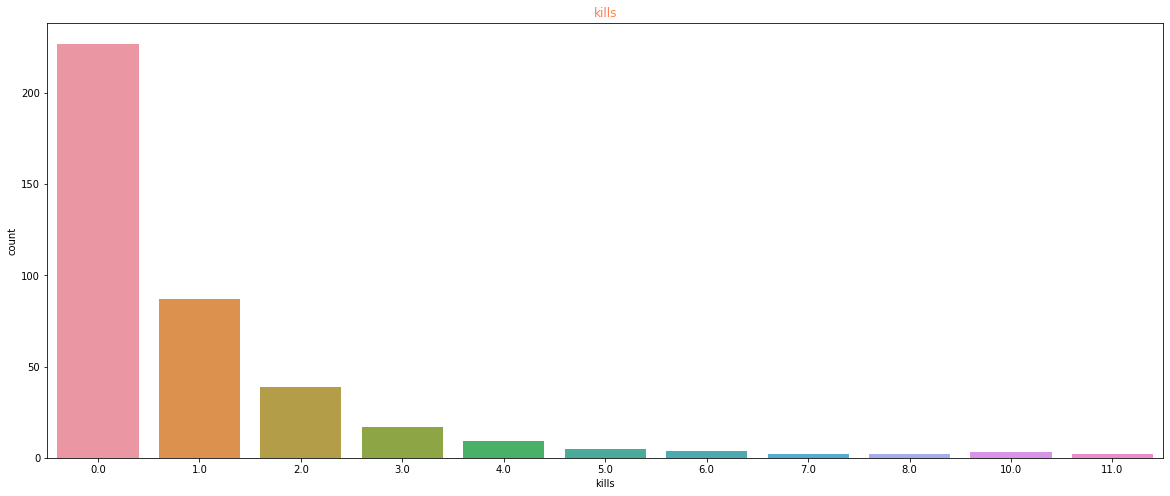

In [766]:
plt.figure(figsize=(20,8))
sns.countplot(df['kills'])
plt.title('kills',color='coral')
print(df['kills'].unique())
print()
print('****************************')
print()
print(df['kills'].value_counts())
print()

### Pie-Chart

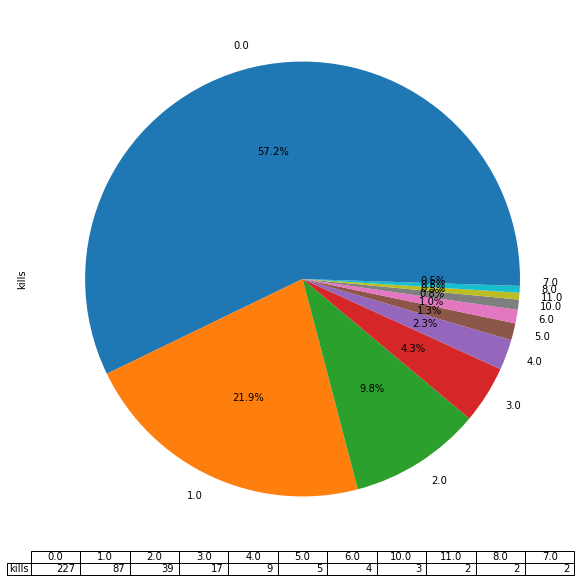

In [767]:
plt.figure(figsize=(10,10))
df.kills.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

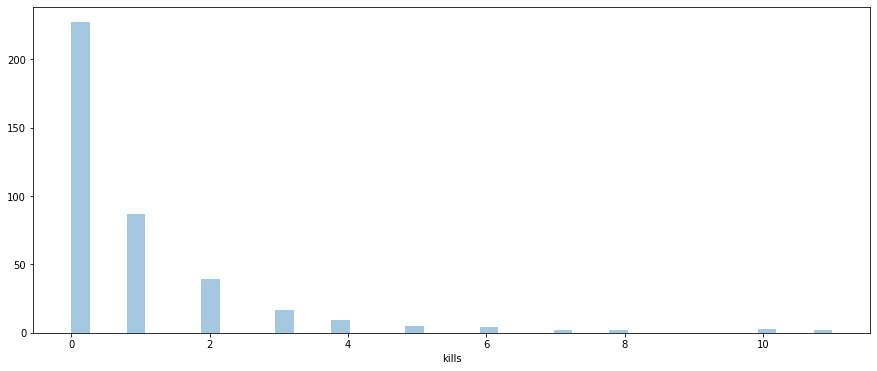

In [768]:
plt.figure(figsize=(15,6))
sns.distplot(df['kills'],kde=False)
plt.show()


### Normal Distribution

In [769]:
plt.figure(figsize=(12,6))
sns.distplot(df['kills'])
plt.show()
print()
print('mean: ',df['kills'].mean())
print('median:',df['kills'].median())
print('mode:',df['kills'].mode())
print()
print('Skewness:',skew(df['kills']))
print('Kurtosis:',kurtosis(df['kills']))
print()


mean:  0.964735516372796
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 3.0598543242183314
Kurtosis: 11.437222204130576



**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

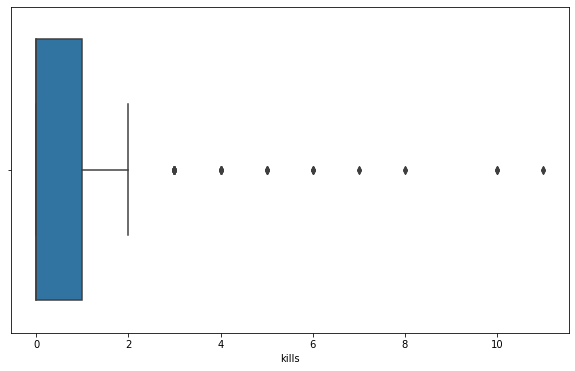

In [770]:
plt.figure(figsize=(10,6))
sns.boxplot(df['kills'])

**Observation:** 

*  There are 7  outliers and many of them present at 0 so median is 0.

*  Very few people are killing with high streak so they treated as Outliers

## killStreaks

### Count Plot

In [771]:
plt.figure(figsize=(20,8))
sns.countplot(df['killStreaks'])
plt.title('killStreaks',color='coral')
print(df['killStreaks'].unique())
print()
print('****************************')
print()
print(df['killStreaks'].value_counts())
print()

[0. 3. 1. 2. 4.]

****************************

0.0    227
1.0    136
2.0     27
3.0      6
4.0      1
Name: killStreaks, dtype: int64



### Pie-Chart

In [772]:
plt.figure(figsize=(10,10))
df.killStreaks.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

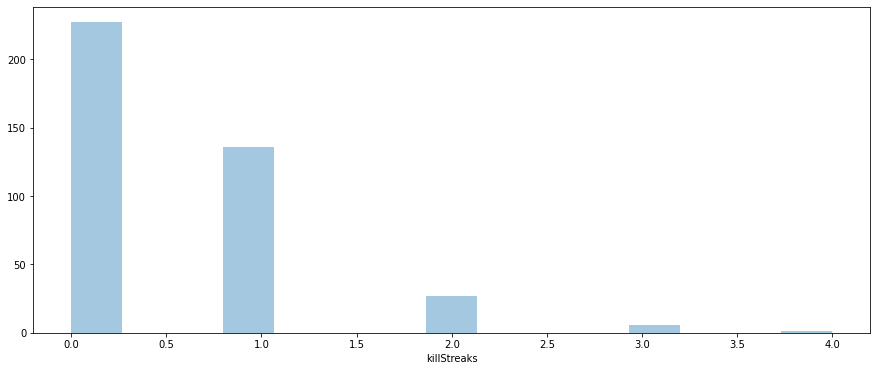

In [773]:
plt.figure(figsize=(15,6))
sns.distplot(df['killStreaks'],kde=False)
plt.show()


### Normal Distribution

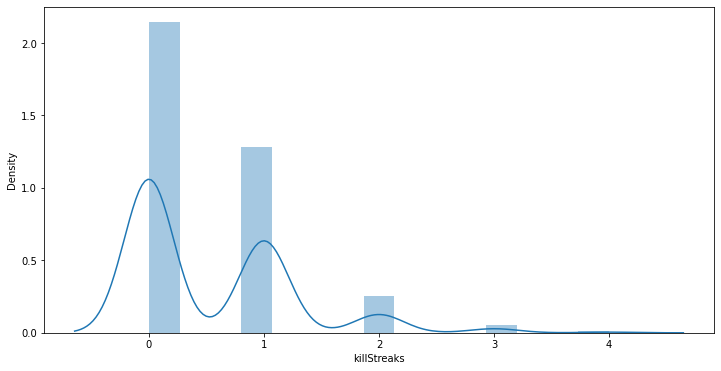


mean:  0.5340050377833753
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 1.371701541029719
Kurtosis: 2.0788256361702215



In [774]:
plt.figure(figsize=(12,6))
sns.distplot(df['killStreaks'])
plt.show()
print()
print('mean: ',df['killStreaks'].mean())
print('median:',df['killStreaks'].median())
print('mode:',df['killStreaks'].mode())
print()
print('Skewness:',skew(df['killStreaks']))
print('Kurtosis:',kurtosis(df['killStreaks']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

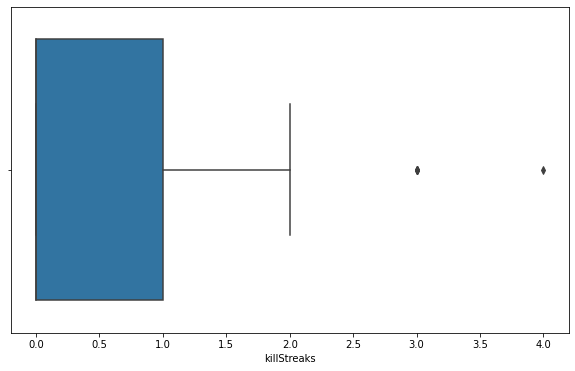

In [775]:
plt.figure(figsize=(10,6))
sns.boxplot(df['killStreaks'])

**Observation:** There is only one outlier present in the graph because only 1 person is having High streak 


## longestKill

### Count Plot

[0.000e+00 5.575e+01 8.390e+01 1.169e+01 4.132e+00 1.786e+02 2.532e+01
 1.065e+02 1.411e+02 7.168e+00 2.160e+01 5.143e+01 4.373e+01 1.677e+02
 1.956e+02 2.644e+01 7.283e+00 2.891e+01 2.171e+01 3.933e+00 6.309e+00
 6.260e+01 2.174e+00 5.635e+00 1.039e+02 6.069e+01 7.982e+00 1.449e+02
 1.091e+02 2.615e+01 2.642e+01 9.070e+01 6.098e+01 6.026e+00 3.053e+00
 5.758e+00 1.406e+02 5.104e+01 1.378e+02 1.911e+02 1.116e+01 8.837e+01
 8.772e+00 2.984e+00 4.960e+00 1.902e+01 1.982e+01 4.718e+01 3.842e+01
 7.072e+01 1.212e+01 5.852e+01 1.988e+01 9.410e+00 5.600e+00 2.989e+01
 1.299e+01 2.086e+02 1.263e+01 1.381e+01 7.118e+00 3.175e+01 2.513e+01
 2.913e+01 7.828e+00 2.373e+01 6.347e+01 2.718e+00 1.786e+01 2.129e+02
 2.529e+01 4.111e+01 1.722e+02 2.085e+02 3.881e+00 4.244e+01 1.453e+02
 3.019e+01 5.682e+01 6.896e+01 1.658e+02 8.133e+00 7.537e+00 8.869e+00
 2.204e+00 1.691e+02 2.204e+01 8.497e+00 2.013e+01 4.935e+01 1.395e+01
 5.679e+01 7.946e+01 4.409e+01 1.485e+01 5.342e+01 3.978e+01 1.070e+01
 5.084

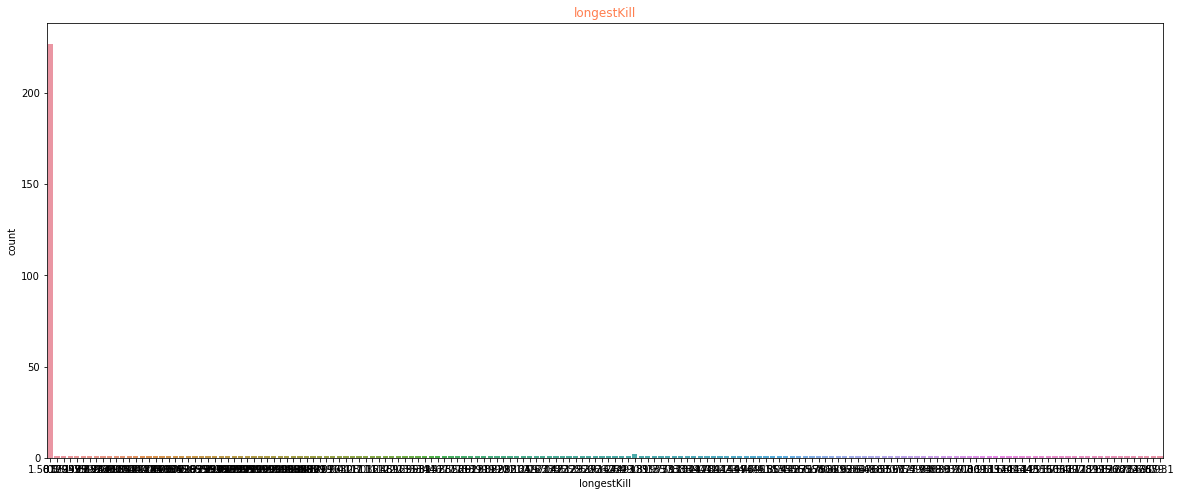

In [776]:
plt.figure(figsize=(20,8))
sns.countplot(df['longestKill'])
plt.title('longestKill',color='coral')
print(df['longestKill'].unique())
print()
print('****************************')
print()
print(df['longestKill'].value_counts())
print()

### Pie-Chart

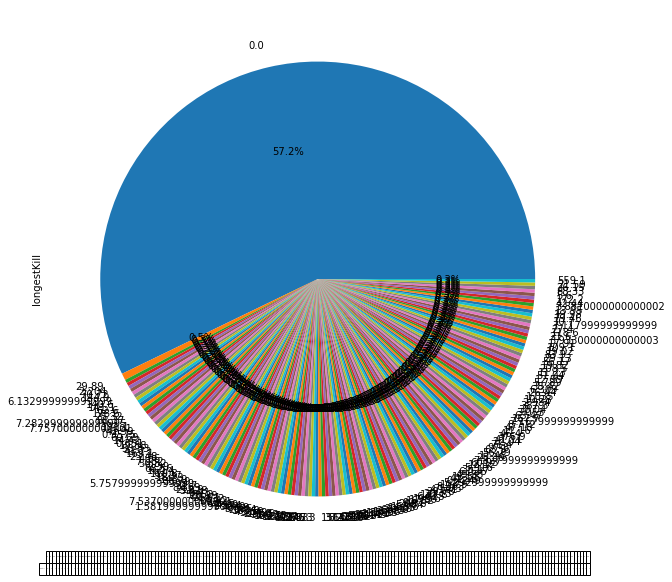

In [777]:
plt.figure(figsize=(10,10))
df.longestKill.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

In [778]:
plt.figure(figsize=(15,6))
sns.distplot(df['longestKill'],kde=False)
plt.show()


### Normal Distribution

In [779]:
plt.figure(figsize=(12,6))
sns.distplot(df['longestKill'])
plt.show()
print()
print('mean: ',df['longestKill'].mean())
print('median:',df['longestKill'].median())
print('mode:',df['longestKill'].mode())
print()
print('Skewness:',skew(df['longestKill']))
print('Kurtosis:',kurtosis(df['longestKill']))
print()


mean:  24.37875919395465
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 4.373736841221248
Kurtosis: 26.790676003085675



**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

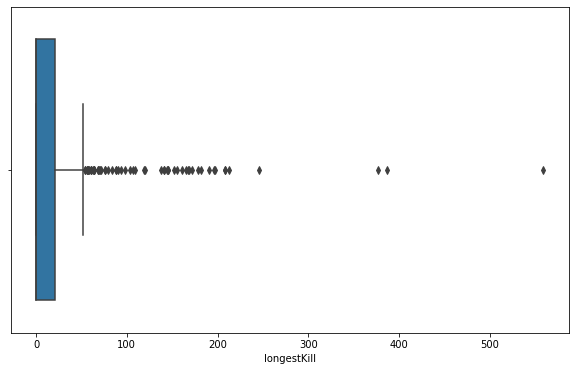

In [780]:
plt.figure(figsize=(10,6))
sns.boxplot(df['longestKill'])

**Observation:** There are lot of outliers. some people are having very long longest streak so we treat them as outliers 

## matchDuration

### Count Plot

[1374. 1924. 1790. 1508. 1285. 1382. 1358. 1854. 1240. 1918. 1524. 1443.
 1902. 1395. 1813. 1400. 1882. 1795. 1313. 1379. 1515. 1839. 1432. 1979.
 1884. 1360. 1727. 1798. 1958. 1769. 1855. 1982. 1875. 1791. 1973. 1391.
 1455. 1957. 1422. 1387. 1910. 1348. 1385. 1370. 1827. 1430. 1377. 1992.
 1257. 1283. 1357. 1820. 1353. 1424. 1327. 1806. 2176. 1341. 1451. 1354.
 1359. 1381. 1305. 1364. 1363. 1879. 1983. 1886. 1961. 1807. 1361. 1967.
 1337. 1417. 1294. 1334. 1971. 1779. 1427. 1913. 1946. 1306. 1289. 1378.
 1914. 1858. 1864. 1492. 1276. 1335. 1388. 1908. 1937. 1890. 1375. 1887.
 1450. 1900. 1932. 1895. 1764. 1338. 1439. 1297. 1852. 1365. 1402. 1127.
 1352. 1835. 1974. 1380. 1331. 1447. 1326. 1771. 1889. 1516. 1396. 1369.
 1865. 1441. 1420. 1397. 1831. 1296. 2099. 1470. 1333. 1936. 1788. 1308.
 1811. 1384. 1421. 1315. 1963. 1845.  482. 1968. 1376. 1336. 1822. 1299.
 1389. 1794. 1782. 1426. 1433. 1814.  894. 1362. 1351. 2056. 1833. 1850.
 1927. 1954. 1871. 1874. 1316. 1409. 1818. 1399. 13

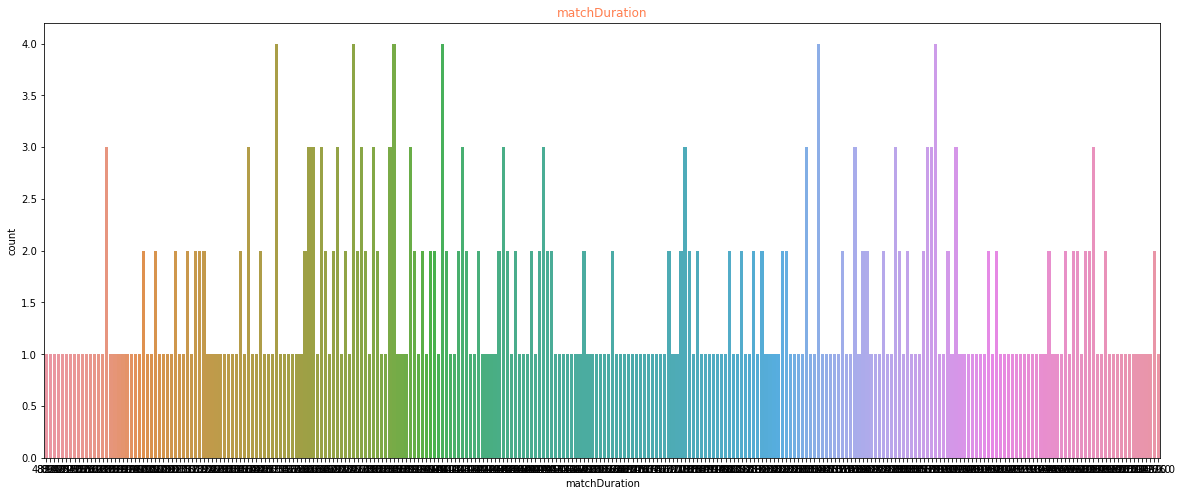

In [781]:
plt.figure(figsize=(20,8))
sns.countplot(df['matchDuration'])
plt.title('matchDuration',color='coral')
print(df['matchDuration'].unique())
print()
print('****************************')
print()
print(df['matchDuration'].value_counts())
print()

### Pie-Chart

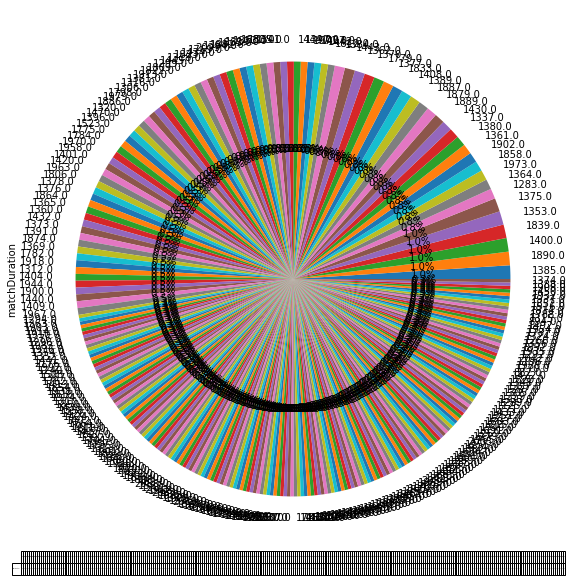

In [782]:
plt.figure(figsize=(10,10))
df.matchDuration.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

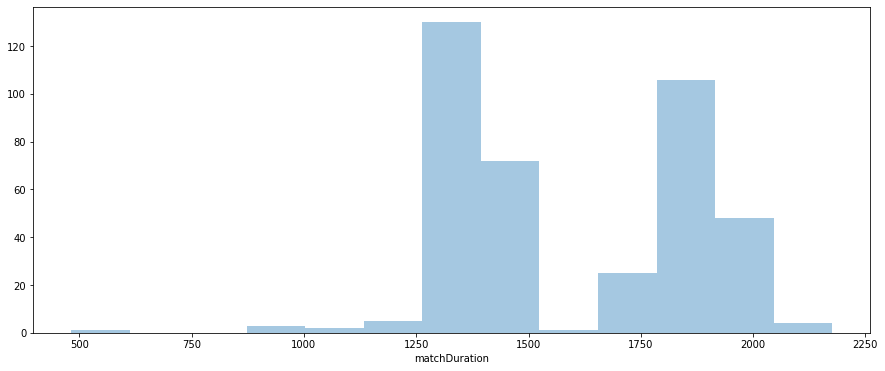

In [783]:
plt.figure(figsize=(15,6))
sns.distplot(df['matchDuration'],kde=False)
plt.show()


### Normal Distribution

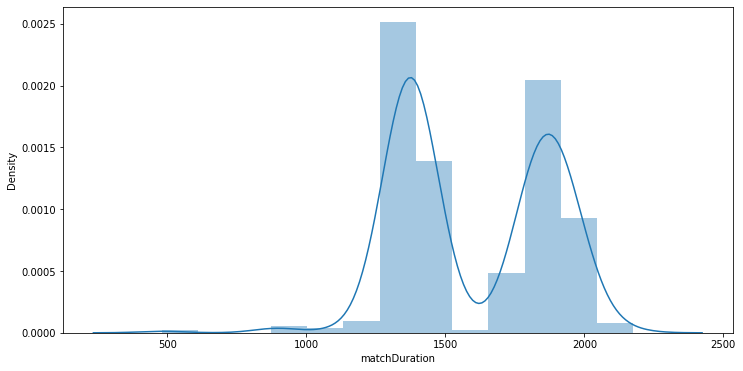


mean:  1599.4584382871537
median: 1453.0
mode: 0    1353.0
1    1375.0
2    1385.0
3    1400.0
4    1839.0
5    1890.0
dtype: float64

Skewness: -0.06807898901007454
Kurtosis: -0.8014961302189461



In [784]:
plt.figure(figsize=(12,6))
sns.distplot(df['matchDuration'])
plt.show()
print()
print('mean: ',df['matchDuration'].mean())
print('median:',df['matchDuration'].median())
print('mode:',df['matchDuration'].mode())
print()
print('Skewness:',skew(df['matchDuration']))
print('Kurtosis:',kurtosis(df['matchDuration']))
print()

**Observation:** 

*   an average one person playing the Pubg for 1560.

### Box-Cox Transformation

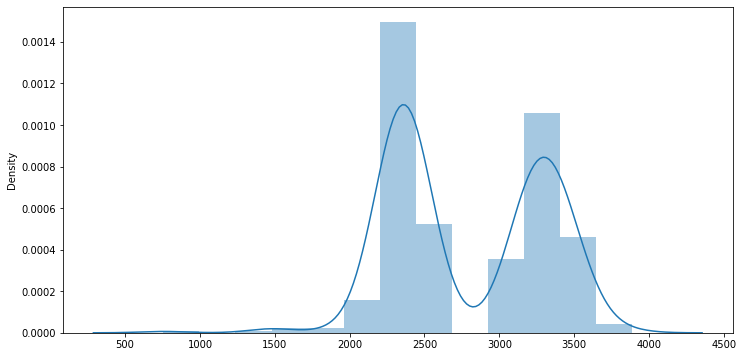



mean:  2786.1873501308664
median: 2506.6071842315614

Skewness: -0.03694374208403098
Kurtosis: -0.909363463126089



In [785]:
plt.figure(figsize=(12,6))
transformed, _ = stats.boxcox(df['matchDuration']) 
#plot the distribution of the transformed data values
sns.distplot(transformed)
plt.show()
print()
print()
print('mean: ',transformed.mean())
print('median:',np.median(transformed))

print()
print('Skewness:',skew(transformed))
print('Kurtosis:',kurtosis(transformed))
print()

**Observation:** 
*   After applying Box-Cox Transformation Graph becomes **Zero-skewed**
*   we can check this by using mean,mode and median. here mean, mode and median are almost same.



### Box Plot

In [786]:
plt.figure(figsize=(10,6))
sns.boxplot(df['matchDuration'])

**Observation:** There are no outliers present in the graph. 

## maxPlace

### Count Plot

In [787]:
plt.figure(figsize=(20,8))
sns.countplot(df['maxPlace'])
plt.title('maxPlace',color='coral')
print(df['maxPlace'].unique())
print()
print('****************************')
print()
print(df['maxPlace'].value_counts())
print()

[50. 31. 47. 48. 97. 32. 46. 28. 30. 93. 95. 27. 29. 49. 26. 24. 25. 33.
 96. 91. 99. 45. 98. 89. 92. 94. 16.  9. 43. 42. 21. 85. 51. 41.]

****************************

28.0    49
27.0    48
29.0    36
49.0    31
30.0    29
48.0    26
47.0    25
26.0    18
50.0    17
97.0    14
46.0    14
31.0    11
95.0    10
98.0     8
24.0     6
25.0     6
94.0     6
96.0     5
45.0     5
92.0     5
99.0     4
89.0     4
93.0     3
16.0     3
32.0     3
42.0     2
91.0     2
85.0     1
21.0     1
33.0     1
43.0     1
9.0      1
51.0     1
41.0     1
Name: maxPlace, dtype: int64



### Pie-Chart

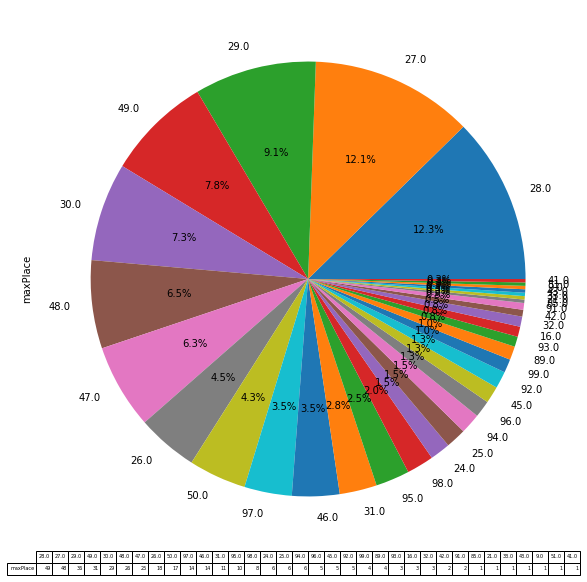

In [788]:
plt.figure(figsize=(10,10))
df.maxPlace.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

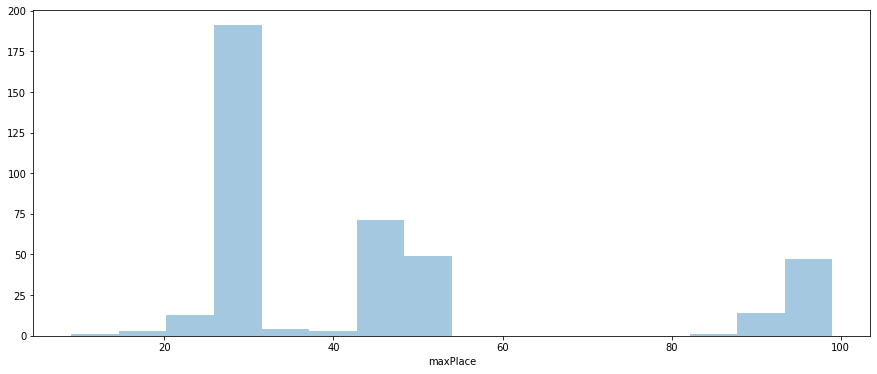

In [789]:
plt.figure(figsize=(15,6))
sns.distplot(df['maxPlace'],kde=False)
plt.show()


### Normal Distribution

In [790]:
plt.figure(figsize=(12,6))
sns.distplot(df['maxPlace'])
plt.show()
print()
print('mean: ',df['maxPlace'].mean())
print('median:',df['maxPlace'].median())
print('mode:',df['maxPlace'].mode())
print()
print('Skewness:',skew(df['maxPlace']))
print('Kurtosis:',kurtosis(df['maxPlace']))
print()


mean:  44.49874055415617
median: 31.0
mode: 0    28.0
dtype: float64

Skewness: 1.3450904100086312
Kurtosis: 0.5085768655700771



**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box-Cox Transformation

In [791]:
plt.figure(figsize=(12,6))
transformed, _ = stats.boxcox(df['maxPlace']) 
#plot the distribution of the transformed data values
sns.distplot(transformed)
plt.show()
print()
print()
print('mean: ',transformed.mean())
print('median:',np.median(transformed))
print('mode:',st.mode(transformed))
print()
print('Skewness:',skew(transformed))
print('Kurtosis:',kurtosis(transformed))
print()



mean:  1.433267196807141
median: 1.4126614585708541
mode: 1.400380798185506

Skewness: -0.02685342768292146
Kurtosis: 1.3118979854174446



**Observation:** 
*   After applying Box-Cox Transformation Graph becomes **Zero-skewed**
*   we can check this by using mean,mode and median. here mean, mode and median are almost same.



### Box Plot

In [792]:
plt.figure(figsize=(10,6))
sns.boxplot(df['maxPlace'])

**Observation:** There are lot of outliers. This outliers are one responsible for not getting normal distribution.

### Removing Outliers

In [793]:
maxPlace_outliers=i_q_r(df['maxPlace'])
print(maxPlace_outliers[0])
print(maxPlace_outliers[1])


Lower limit is:  -3.5
Upper limit is:  80.5
-3.5
80.5


## numGroups

### Count Plot

[50. 29. 41. 46. 95. 48. 47. 26. 31. 43. 27. 30. 84. 88. 44. 94. 28. 92.
 25. 22. 24. 81. 32. 90. 89. 49. 45. 91. 79. 42. 16. 85.  8. 93. 40. 37.
  2. 97. 23. 96. 21. 98. 87.]

****************************

27.0    50
26.0    37
47.0    31
28.0    31
29.0    25
25.0    25
46.0    21
48.0    18
30.0    16
44.0    12
45.0    12
95.0    10
24.0    10
49.0     7
43.0     7
94.0     7
22.0     5
88.0     5
31.0     5
42.0     5
93.0     5
92.0     4
50.0     4
90.0     4
89.0     4
97.0     4
96.0     4
91.0     4
85.0     3
41.0     3
87.0     2
98.0     2
32.0     2
79.0     2
16.0     2
40.0     2
84.0     1
8.0      1
37.0     1
2.0      1
23.0     1
21.0     1
81.0     1
Name: numGroups, dtype: int64



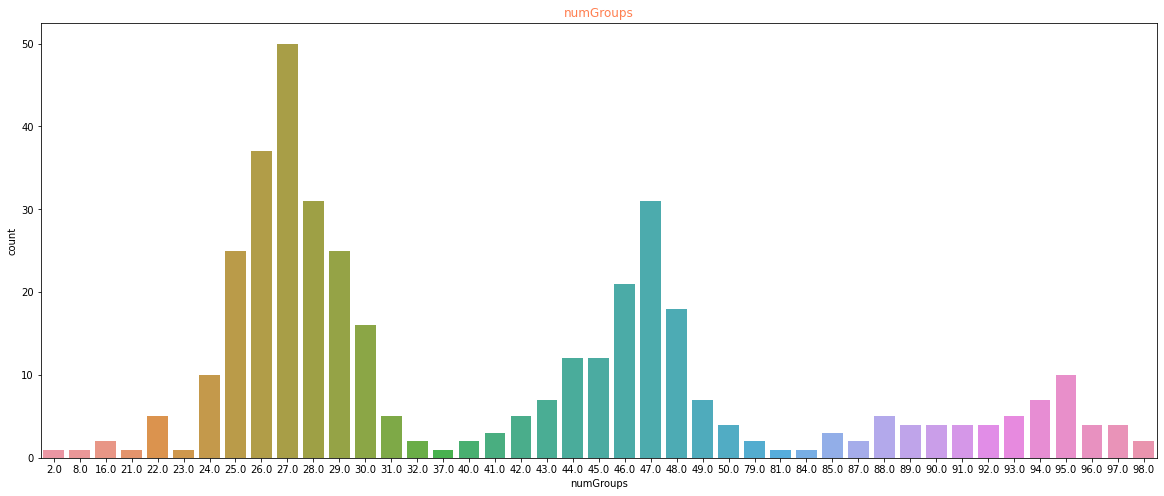

In [794]:
plt.figure(figsize=(20,8))
sns.countplot(df['numGroups'])
plt.title('numGroups',color='coral')
print(df['numGroups'].unique())
print()
print('****************************')
print()
print(df['numGroups'].value_counts())
print()

### Pie-Chart

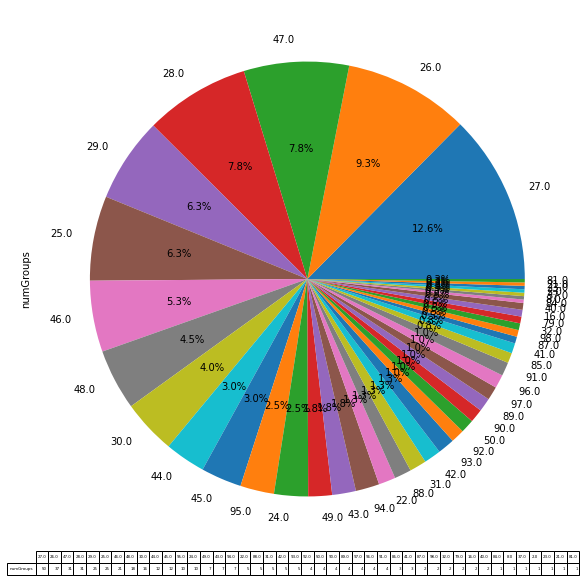

In [795]:
plt.figure(figsize=(10,10))
df.numGroups.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

In [796]:
plt.figure(figsize=(15,6))
sns.distplot(df['numGroups'],kde=False)
plt.show()


### Normal Distribution

In [797]:
plt.figure(figsize=(12,6))
sns.distplot(df['numGroups'])
plt.show()
print()
print('mean: ',df['numGroups'].mean())
print('median:',df['numGroups'].median())
print('mode:',df['numGroups'].mode())
print()
print('Skewness:',skew(df['numGroups']))
print('Kurtosis:',kurtosis(df['numGroups']))
print()


mean:  42.80856423173803
median: 30.0
mode: 0    27.0
dtype: float64

Skewness: 1.345025832400837
Kurtosis: 0.569845695489513



**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box-Cox Transformation

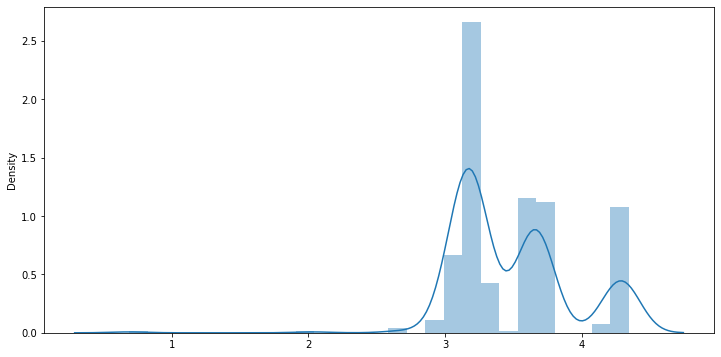



mean:  3.4834614334509135
median: 3.268342949953754
mode: 3.1709839059043063

Skewness: -0.012446808447159013
Kurtosis: 3.439833478283819



In [798]:
plt.figure(figsize=(12,6))
transformed, _ = stats.boxcox(df['numGroups']) 
#plot the distribution of the transformed data values
sns.distplot(transformed)
plt.show()
print()
print()
print('mean: ',transformed.mean())
print('median:',np.median(transformed))
print('mode:',st.mode(transformed))
print()
print('Skewness:',skew(transformed))
print('Kurtosis:',kurtosis(transformed))
print()

**Observation:** 
*   After applying Box-Cox Transformation Graph becomes **Zero-skewed**
*   we can check this by using mean,mode and median. here mean, mode and median are almost same.



### Box Plot

In [799]:
plt.figure(figsize=(10,6))
sns.boxplot(df['numGroups'])

**Observation:** There are lot of outliers. This outliers are one responsible for not getting normal distribution.

## rankPoints

### Count Plot

[-1.000e+00  1.496e+03  1.562e+03  1.497e+03  1.424e+03  1.511e+03
  1.499e+03  1.578e+03  1.450e+03  1.498e+03  1.500e+03  1.443e+03
  1.679e+03  1.486e+03  1.521e+03  1.481e+03  1.507e+03  0.000e+00
  1.326e+03  1.480e+03  1.453e+03  1.420e+03  1.483e+03  1.591e+03
  1.425e+03  1.476e+03  1.942e+03  1.516e+03  1.468e+03  1.440e+03
  1.553e+03  1.489e+03  1.494e+03  1.458e+03  1.495e+03  1.556e+03
  1.348e+03  1.534e+03  1.330e+03  1.463e+03  1.510e+03  1.477e+03
  1.546e+03  2.384e+03  1.378e+03  1.469e+03  1.384e+03  1.473e+03
  1.488e+03  1.390e+03  1.427e+03  1.446e+03  1.493e+03  1.532e+03
  1.526e+03  1.504e+03  1.613e+03  1.561e+03  1.373e+03  1.485e+03
  1.518e+03  1.502e+03  1.596e+03  1.514e+03  1.461e+03  1.540e+03
  1.586e+03  1.543e+03  1.472e+03  1.484e+03  1.482e+03  1.508e+03
  1.475e+03  1.492e+03  1.391e+03  1.531e+03  1.093e+03  1.417e+03
  1.412e+03  1.528e+03  1.428e+03  1.419e+03  1.522e+03  1.421e+03
  1.423e+03  1.403e+03  1.331e+03  1.552e+03  1.491e+03  1.456

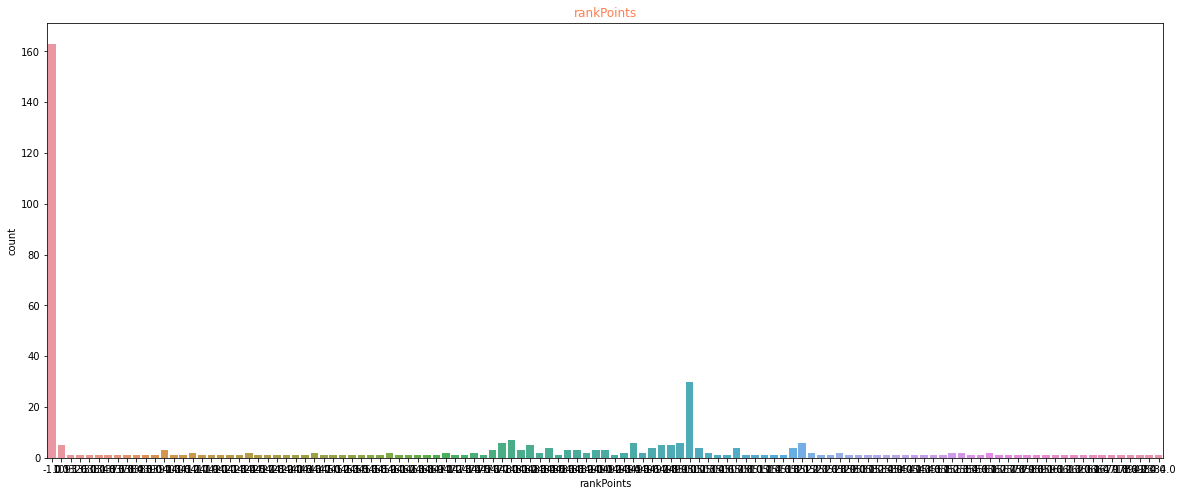

In [800]:
plt.figure(figsize=(20,8))
sns.countplot(df['rankPoints'])
plt.title('rankPoints',color='coral')
print(df['rankPoints'].unique())
print()
print('****************************')
print()
print(df['rankPoints'].value_counts())
print()

### Pie-Chart

In [801]:
plt.figure(figsize=(10,10))
df.rankPoints.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

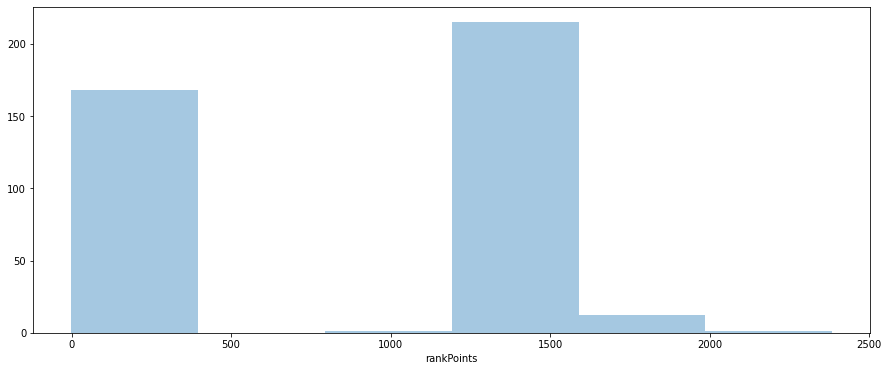

In [802]:
plt.figure(figsize=(15,6))
sns.distplot(df['rankPoints'],kde=False)
plt.show()


### Normal Distribution

In [803]:
plt.figure(figsize=(12,6))
sns.distplot(df['rankPoints'])
plt.show()
print()
print('mean: ',df['rankPoints'].mean())
print('median:',df['rankPoints'].median())
print('mode:',df['rankPoints'].mode())
print()
print('Skewness:',skew(df['rankPoints']))
print('Kurtosis:',kurtosis(df['rankPoints']))
print()


mean:  864.72040302267
median: 1446.0
mode: 0   -1.0
dtype: float64

Skewness: -0.2770998544403509
Kurtosis: -1.8589471351657292



### Box Plot

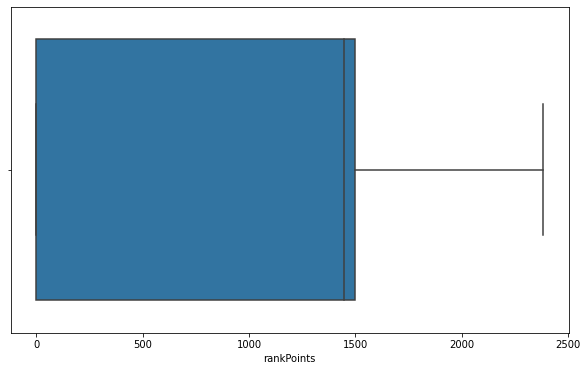

In [804]:
plt.figure(figsize=(10,6))
sns.boxplot(df['rankPoints'])

**Observation:** There are no outliers present in the graph.

## revives

### Count Plot

[0. 1. 3. 2.]

****************************

0.0    344
1.0     45
2.0      6
3.0      2
Name: revives, dtype: int64



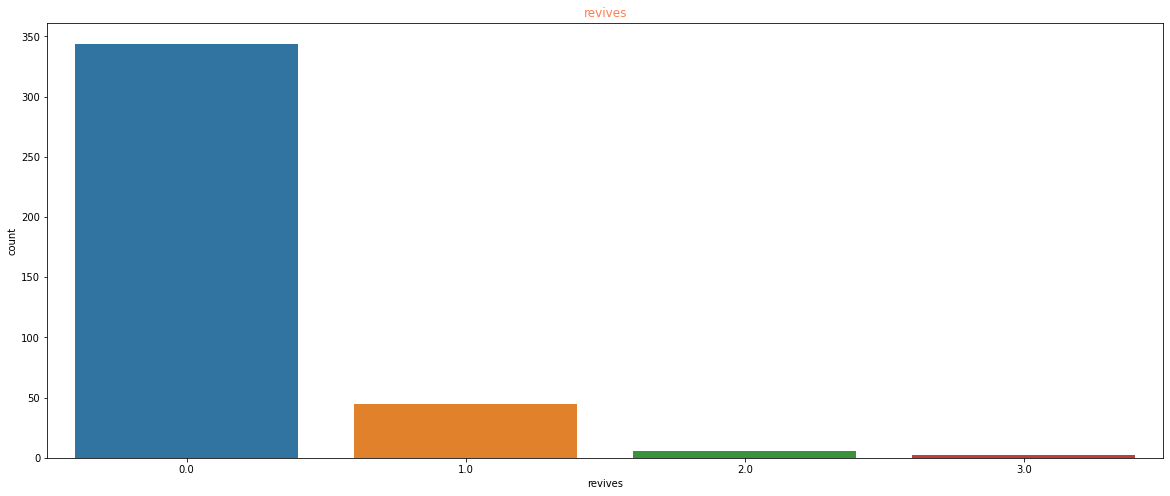

In [805]:
plt.figure(figsize=(20,8))
sns.countplot(df['revives'])
plt.title('revives',color='coral')
print(df['revives'].unique())
print()
print('****************************')
print()
print(df['revives'].value_counts())
print()

### Pie-Chart

In [806]:
plt.figure(figsize=(10,10))
df.revives.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

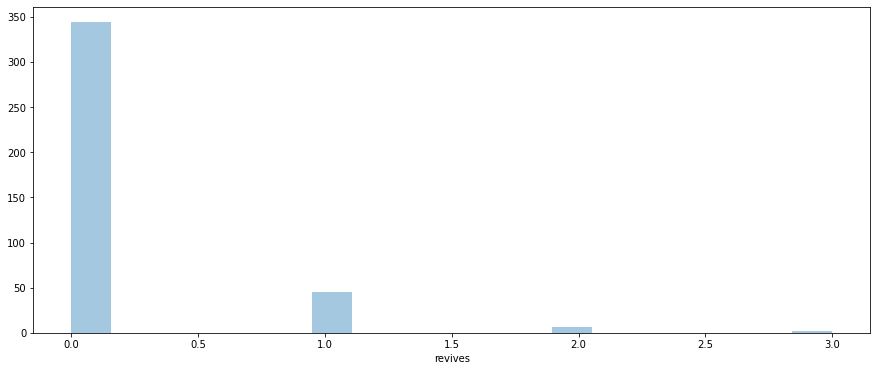

In [807]:
plt.figure(figsize=(15,6))
sns.distplot(df['revives'],kde=False)
plt.show()


### Normal Distribution

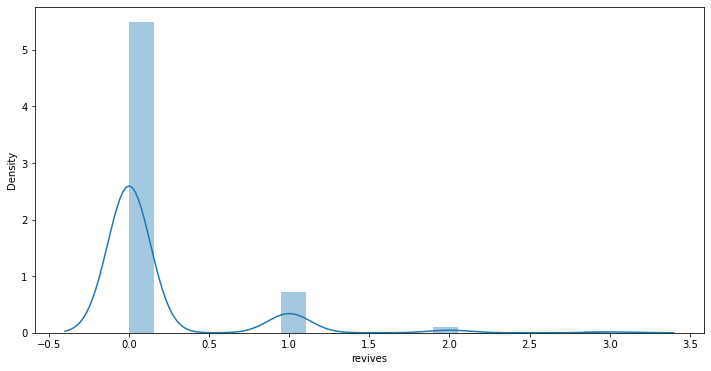


mean:  0.15869017632241814
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 3.206908444885461
Kurtosis: 11.8692980636471



In [808]:
plt.figure(figsize=(12,6))
sns.distplot(df['revives'])
plt.show()
print()
print('mean: ',df['revives'].mean())
print('median:',df['revives'].median())
print('mode:',df['revives'].mode())
print()
print('Skewness:',skew(df['revives']))
print('Kurtosis:',kurtosis(df['revives']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

In [809]:
plt.figure(figsize=(10,6))
sns.boxplot(df['revives'])

**Observation:** There are 3 outliers present in the graph because very less people are getting high revives. 

## rideDistance

### Count Plot

In [810]:
plt.figure(figsize=(20,8))
sns.countplot(df['rideDistance'])
plt.title('rideDistance',color='coral')
print(df['rideDistance'].unique())
print()
print('****************************')
print()
print(df['rideDistance'].value_counts())
print()

[3.342e+02 6.639e+03 4.917e+00 0.000e+00 7.472e+02 4.630e+03 2.613e+03
 2.452e+02 3.229e+02 4.874e+03 3.811e+03 2.951e+03 3.163e+03 1.489e+03
 6.966e+03 8.390e+02 4.609e+03 1.360e+03 2.861e+02 1.471e+03 3.433e+03
 8.992e+02 6.252e+03 2.872e+03 1.158e+03 2.128e+02 1.240e-02 3.191e+03
 4.246e+02 6.988e+03 2.657e+03 3.555e+03 1.658e+03 2.156e+02 6.604e+03
 4.638e+03 5.485e+03 1.420e+03 4.426e+03 6.039e+02 1.165e+04 3.244e+03
 4.640e+03 1.910e+03 1.459e+03 1.501e+03 2.737e+03 1.173e+03 2.783e+03
 5.204e+02 4.098e+02 2.565e+02 3.987e+03 4.812e+02 5.426e+03 6.674e+02
 5.904e+03 1.279e+03 1.088e+03 2.768e+03 1.030e+03 9.436e+02 4.092e+03
 2.060e+03 2.134e+03 4.172e+03 1.454e+03 9.068e+02 2.278e+03 3.361e+03
 1.866e+03 3.672e+02 1.326e+03 5.025e+02 5.725e+02 4.687e+03 1.116e+03
 4.081e+03 3.409e+03 7.296e+03 6.809e+02 7.511e+03 4.988e+01 2.825e+02
 4.438e+03 5.689e+02 4.746e+03 3.606e+02 2.325e+03 2.374e+03 4.859e+03
 2.127e+03 1.060e-02 5.461e+03 7.309e+02 2.915e+03 1.198e+02 5.757e+02
 4.875

### Pie-Chart

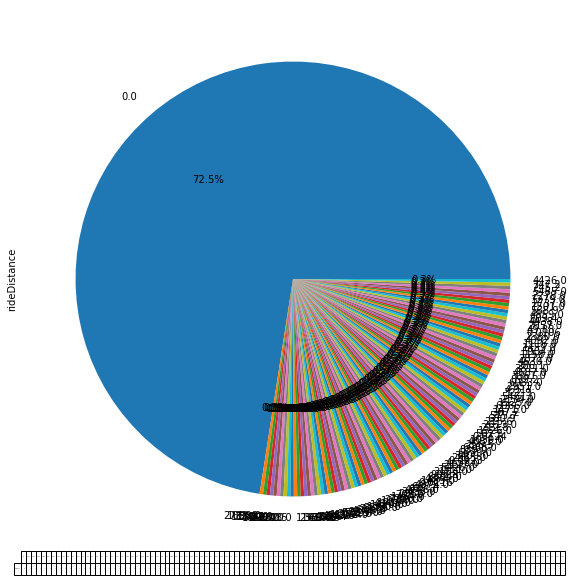

In [811]:
plt.figure(figsize=(10,10))
df.rideDistance.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

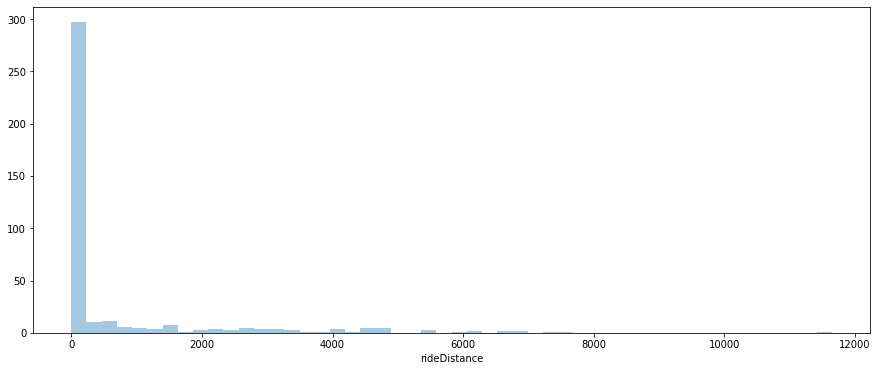

In [812]:
plt.figure(figsize=(15,6))
sns.distplot(df['rideDistance'],kde=False)
plt.show()


### Normal Distribution

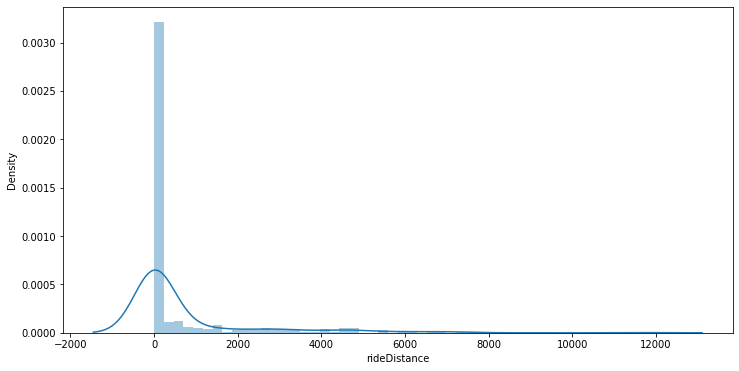


mean:  683.0776672544081
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 2.9079738143194787
Kurtosis: 9.516526001821331



In [813]:
plt.figure(figsize=(12,6))
sns.distplot(df['rideDistance'])
plt.show()
print()
print('mean: ',df['rideDistance'].mean())
print('median:',df['rideDistance'].median())
print('mode:',df['rideDistance'].mode())
print()
print('Skewness:',skew(df['rideDistance']))
print('Kurtosis:',kurtosis(df['rideDistance']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

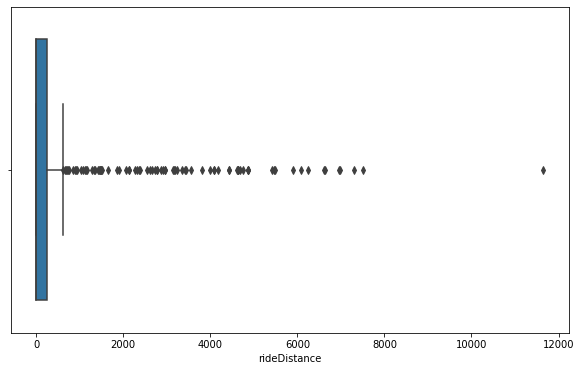

In [814]:
plt.figure(figsize=(10,6))
sns.boxplot(df['rideDistance'])

**Observation:** There are lot of outliers. This outliers are one responsible for not getting normal distribution.

## roadKills

### Count Plot

[0. 1.]

****************************

0.0    396
1.0      1
Name: roadKills, dtype: int64



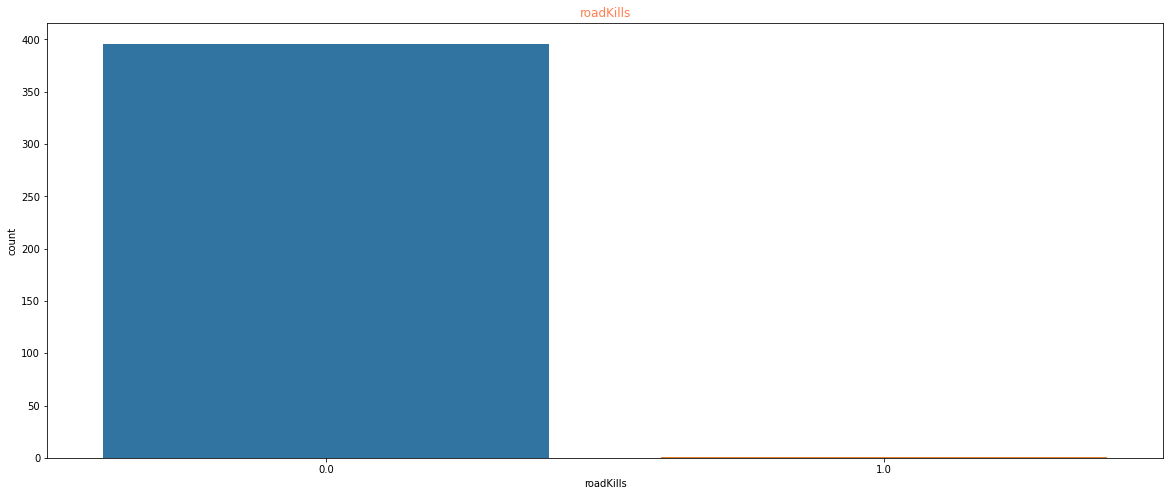

In [815]:
plt.figure(figsize=(20,8))
sns.countplot(df['roadKills'])
plt.title('roadKills',color='coral')
print(df['roadKills'].unique())
print()
print('****************************')
print()
print(df['roadKills'].value_counts())
print()

### Pie-Chart

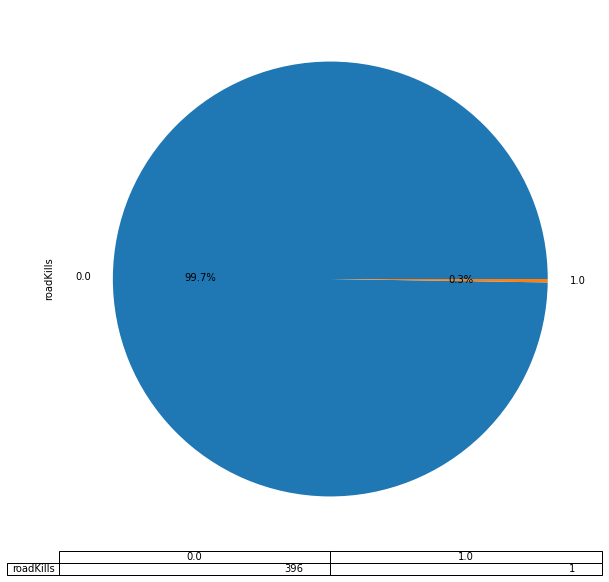

In [816]:
plt.figure(figsize=(10,10))
df.roadKills.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

In [817]:
plt.figure(figsize=(15,6))
sns.distplot(df['roadKills'],kde=False)
plt.show()


### Normal Distribution

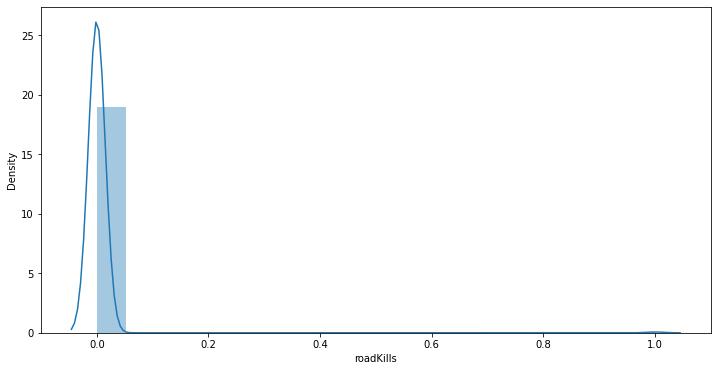


mean:  0.0025188916876574307
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 19.849496851369448
Kurtosis: 392.00252525252546



In [818]:
plt.figure(figsize=(12,6))
sns.distplot(df['roadKills'])
plt.show()
print()
print('mean: ',df['roadKills'].mean())
print('median:',df['roadKills'].median())
print('mode:',df['roadKills'].mode())
print()
print('Skewness:',skew(df['roadKills']))
print('Kurtosis:',kurtosis(df['roadKills']))
print()

**Observation:** 

* Very less people are killed in road

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

In [819]:
plt.figure(figsize=(10,6))
sns.boxplot(df['roadKills'])

**Observation:** very few people are killed in road and it is treated as outlier

## swimDistance

### Count Plot

In [820]:
plt.figure(figsize=(20,8))
sns.countplot(df['swimDistance'])
plt.title('swimDistance',color='coral')
print(df['swimDistance'].unique())
print()
print('****************************')
print()
print(df['swimDistance'].value_counts())
print()

[  0.    229.4    61.22  104.7     3.456  14.72  103.6    14.31   19.45
  25.13   19.85   73.7    13.65    3.909   3.122   3.939]

****************************

0.000      382
13.650       1
3.909        1
104.700      1
3.122        1
19.850       1
103.600      1
61.220       1
14.720       1
3.939        1
73.700       1
229.400      1
19.450       1
14.310       1
25.130       1
3.456        1
Name: swimDistance, dtype: int64



### Pie-Chart

In [821]:
plt.figure(figsize=(10,10))
df.swimDistance.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

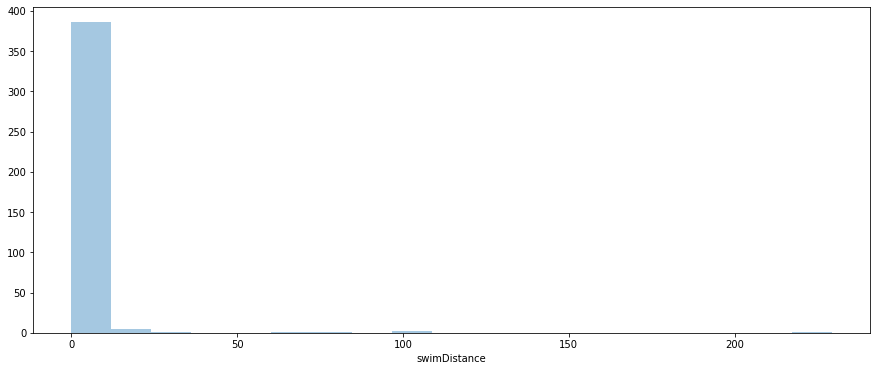

In [822]:
plt.figure(figsize=(15,6))
sns.distplot(df['swimDistance'],kde=False)
plt.show()


### Normal Distribution

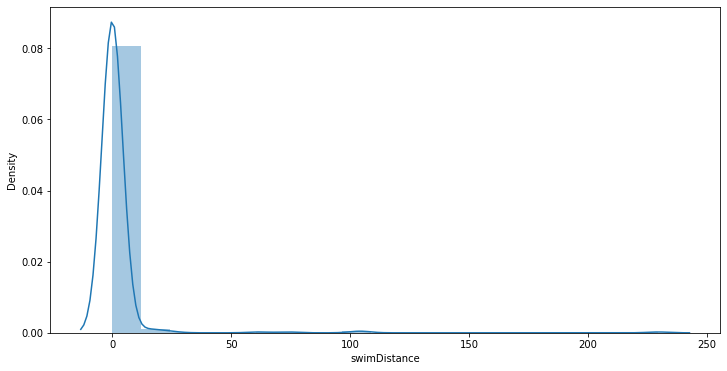


mean:  1.7485037783375315
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 11.839625182712505
Kurtosis: 161.36715068746506



In [823]:
plt.figure(figsize=(12,6))
sns.distplot(df['swimDistance'])
plt.show()
print()
print('mean: ',df['swimDistance'].mean())
print('median:',df['swimDistance'].median())
print('mode:',df['swimDistance'].mode())
print()
print('Skewness:',skew(df['swimDistance']))
print('Kurtosis:',kurtosis(df['swimDistance']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

In [824]:
plt.figure(figsize=(10,6))
sns.boxplot(df['swimDistance'])

**Observation:** There are lot of outliers. This outliers are one responsible for not getting normal distribution.

## teamKills

### Count Plot

[0. 1.]

****************************

0.0    388
1.0      9
Name: teamKills, dtype: int64



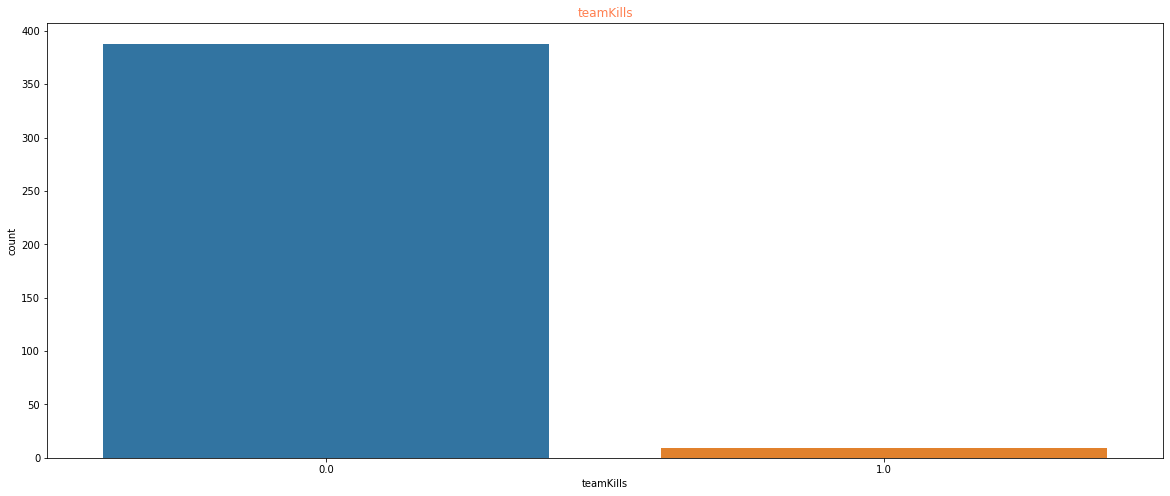

In [825]:
plt.figure(figsize=(20,8))
sns.countplot(df['teamKills'])
plt.title('teamKills',color='coral')
print(df['teamKills'].unique())
print()
print('****************************')
print()
print(df['teamKills'].value_counts())
print()

### Pie-Chart

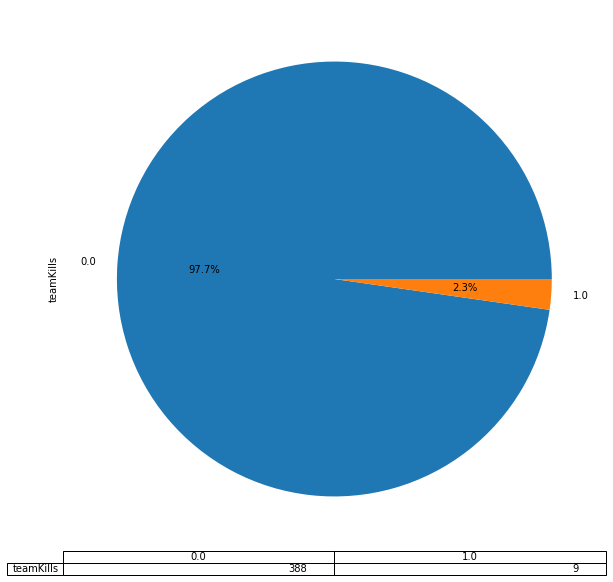

In [826]:
plt.figure(figsize=(10,10))
df.teamKills.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

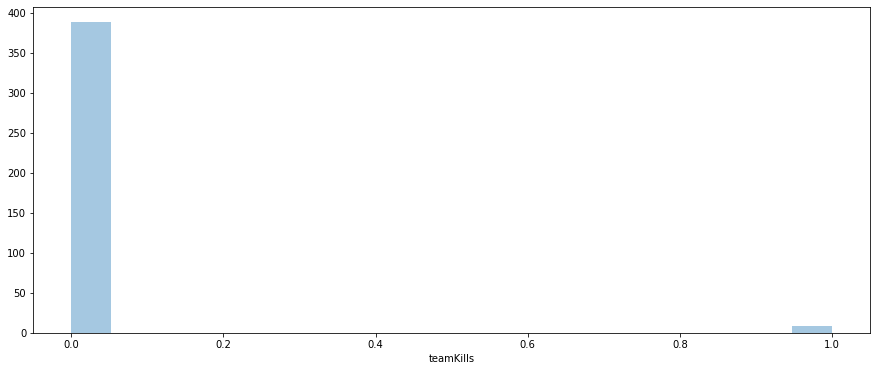

In [827]:
plt.figure(figsize=(15,6))
sns.distplot(df['teamKills'],kde=False)
plt.show()


### Normal Distribution

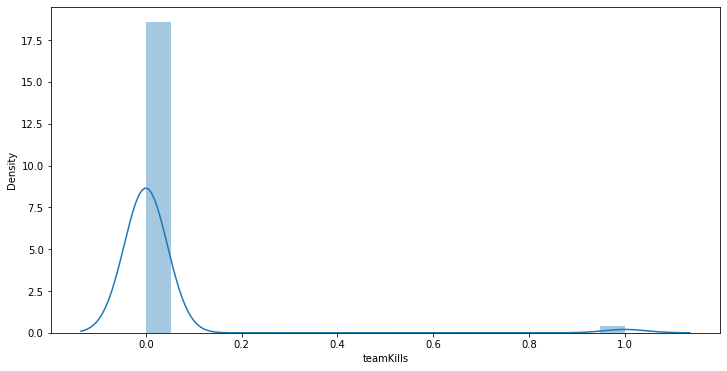


mean:  0.022670025188916875
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 6.413603276427359
Kurtosis: 39.13430698739975



In [828]:
plt.figure(figsize=(12,6))
sns.distplot(df['teamKills'])
plt.show()
print()
print('mean: ',df['teamKills'].mean())
print('median:',df['teamKills'].median())
print('mode:',df['teamKills'].mode())
print()
print('Skewness:',skew(df['teamKills']))
print('Kurtosis:',kurtosis(df['teamKills']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

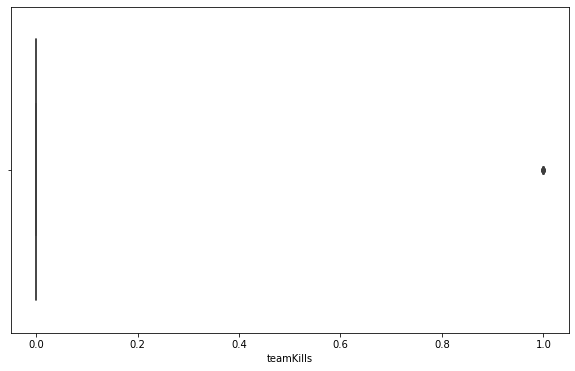

In [829]:
plt.figure(figsize=(10,6))
sns.boxplot(df['teamKills'])

**Observation:** There is only one outlier present in the graph

## vehicleDestroys

### Count Plot

[0. 1.]

****************************

0.0    396
1.0      1
Name: vehicleDestroys, dtype: int64



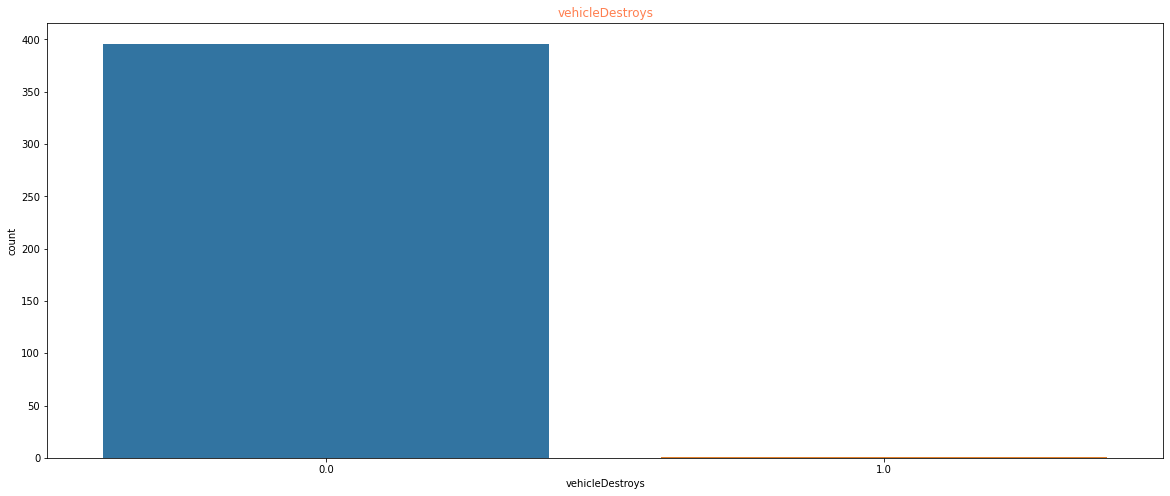

In [830]:
plt.figure(figsize=(20,8))
sns.countplot(df['vehicleDestroys'])
plt.title('vehicleDestroys',color='coral')
print(df['vehicleDestroys'].unique())
print()
print('****************************')
print()
print(df['vehicleDestroys'].value_counts())
print()

### Pie-Chart

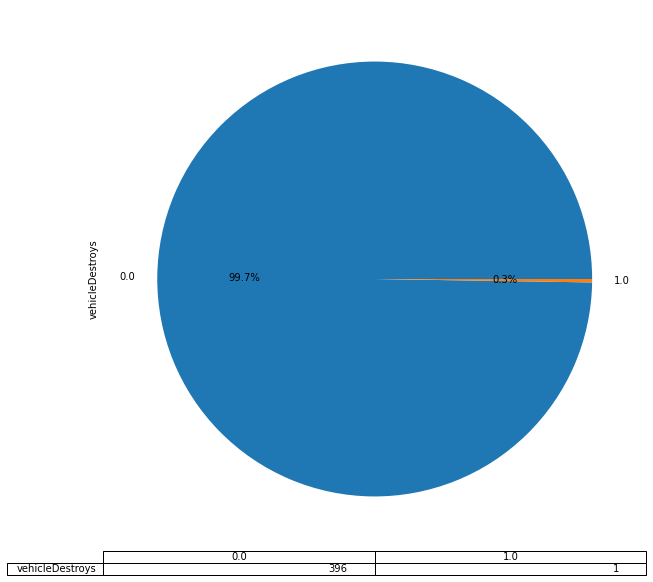

In [831]:
plt.figure(figsize=(10,10))
df.vehicleDestroys.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

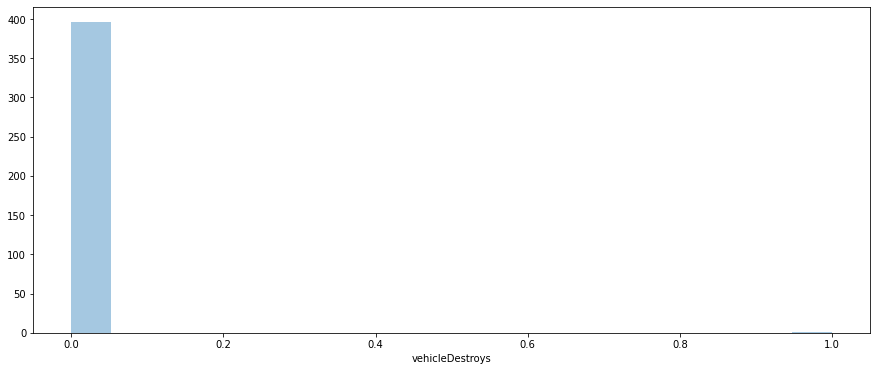

In [832]:
plt.figure(figsize=(15,6))
sns.distplot(df['vehicleDestroys'],kde=False)
plt.show()


### Normal Distribution

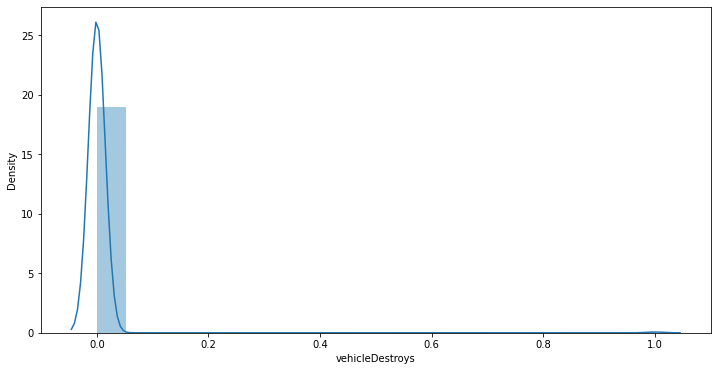


mean:  0.0025188916876574307
median: 0.0
mode: 0    0.0
dtype: float64

Skewness: 19.84949685136944
Kurtosis: 392.0025252525253



In [833]:
plt.figure(figsize=(12,6))
sns.distplot(df['vehicleDestroys'])
plt.show()
print()
print('mean: ',df['vehicleDestroys'].mean())
print('median:',df['vehicleDestroys'].median())
print('mode:',df['vehicleDestroys'].mode())
print()
print('Skewness:',skew(df['vehicleDestroys']))
print('Kurtosis:',kurtosis(df['vehicleDestroys']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

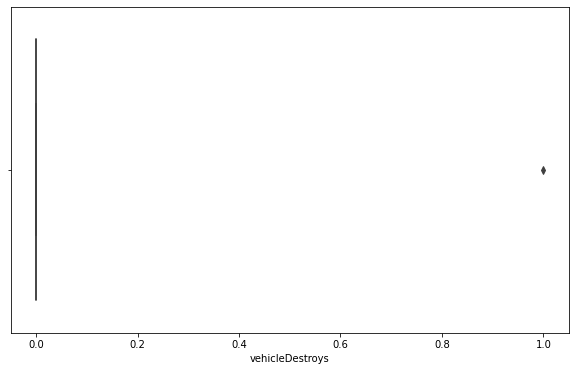

In [834]:
plt.figure(figsize=(10,6))
sns.boxplot(df['vehicleDestroys'])

**Observation:** There is only one outlier present in the graph



## walkDistance

### Count Plot

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(df['walkDistance'])
plt.title('walkDistance',color='coral')
print(df['walkDistance'].unique())
print()
print('****************************')
print()
print(df['walkDistance'].value_counts())
print()

[8.029e+02 1.285e+03 2.649e+03 3.796e+01 3.531e+02 1.372e+03 5.220e+01
 3.161e+02 1.113e+03 2.145e+02 1.904e+02 2.863e+02 3.046e+03 6.320e+01
 2.550e+03 1.869e+03 2.445e+03 2.954e+03 1.312e+02 3.340e+02 3.379e+01
 9.917e+02 2.319e+02 1.505e+02 6.253e+02 4.033e+01 2.259e+02 2.909e+03
 1.620e+03 2.662e+03 1.037e+03 2.352e+02 2.271e+03 1.116e+02 7.546e+02
 5.105e+01 1.906e+03 9.755e+01 1.650e+02 1.366e+02 3.100e+03 6.249e+02
 3.199e+03 2.618e+03 3.227e+01 2.770e+03 6.366e+01 2.003e+03 4.164e+02
 1.455e+03 1.432e+03 1.925e+03 2.616e+03 8.056e+01 0.000e+00 4.403e+02
 2.995e+00 2.218e+01 1.681e+02 1.277e+02 3.618e+03 4.406e+02 5.878e+01
 1.532e+01 8.897e+02 1.581e+01 2.178e+03 1.747e+02 8.455e+02 8.742e+01
 1.797e+02 8.267e+02 1.233e+03 6.757e+03 1.526e+03 1.107e+02 1.240e+02
 2.269e+03 1.824e+01 1.248e+03 2.034e+03 2.887e+03 2.648e+01 1.987e+02
 9.521e+00 1.053e+03 3.005e+03 2.632e+03 2.107e+02 2.818e+03 2.830e+03
 1.079e+01 5.021e+01 2.614e+03 3.209e+02 1.924e+03 5.249e+01 3.888e+03
 3.230

### Pie-Chart

In [ ]:
plt.figure(figsize=(10,10))
df.walkDistance.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

In [ ]:
plt.figure(figsize=(15,6))
sns.distplot(df['walkDistance'],kde=False)
plt.show()


### Normal Distribution

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(df['walkDistance'])
plt.show()
print()
print('mean: ',df['walkDistance'].mean())
print('median:',df['walkDistance'].median())
print('mode:',df['walkDistance'].mode())
print()
print('Skewness:',skew(df['walkDistance']))
print('Kurtosis:',kurtosis(df['walkDistance']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box Plot

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(df['walkDistance'])

**Observation:** 

*  very less people are travelled 5000 meters and they treated as outliers

## weaponsAcquired

### Count Plot

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(df['weaponsAcquired'])
plt.title('weaponsAcquired',color='coral')
print(df['weaponsAcquired'].unique())
print()
print('****************************')
print()
print(df['weaponsAcquired'].value_counts())
print()

**Observation:** The no of people from the weaponsAcquired of 17 was increases until it reaches maximum count (i.e is upto the age of 36) Then its starts decreasing. 

### Pie-Chart

In [ ]:
plt.figure(figsize=(10,10))
df.weaponsAcquired.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

In [ ]:
plt.figure(figsize=(15,6))
sns.distplot(df['weaponsAcquired'],kde=False)
plt.show()


### Normal Distribution

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(df['weaponsAcquired'])
plt.show()
print()
print('mean: ',df['weaponsAcquired'].mean())
print('median:',df['weaponsAcquired'].median())
print('mode:',df['weaponsAcquired'].mode())
print()
print('Skewness:',skew(df['weaponsAcquired']))
print('Kurtosis:',kurtosis(df['weaponsAcquired']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


## winPoints

### Count Plot

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(df['winPoints'])
plt.title('winPoints',color='coral')
print(df['winPoints'].unique())
print()
print('****************************')
print()
print(df['winPoints'].value_counts())
print()

**Observation:** The no of people from the winPoints of 17 was increases until it reaches maximum count (i.e is upto the winPoints of 36) Then its starts decreasing. 

### Pie-Chart

In [ ]:
plt.figure(figsize=(10,10))
df.winPoints.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

In [ ]:
plt.figure(figsize=(15,6))
sns.distplot(df['winPoints'],kde=False)
plt.show()


### Normal Distribution

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(df['winPoints'])
plt.show()
print()
print('mean: ',df['winPoints'].mean())
print('median:',df['winPoints'].median())
print('mode:',df['winPoints'].mode())
print()
print('Skewness:',skew(df['winPoints']))
print('Kurtosis:',kurtosis(df['winPoints']))
print()

**Observation:** 

*   The above graph is Positively Skewed normal Distribution.
*   Or we can check this by using mean,mode and median. Here $mean>median>mode$ . so it is Positively Skewed normal Distribution.


### Box plot

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(df['winPoints'])

**Observation:** There is only one outlier present in the graph

## winPlacePerc

### Count Plot

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(df['winPlacePerc'])
plt.title('winPlacePerc',color='coral')
print(df['winPlacePerc'].unique())
print()
print('****************************')
print()
print(df['winPlacePerc'].value_counts())
print()

**Observation:** The no of people from the winPlacePerc of 17 was increases until it reaches maximum count (i.e is upto the winPlacePerc of 36) Then its starts decreasing. 

### Pie-Chart

In [ ]:
plt.figure(figsize=(10,10))
df.winPlacePerc.value_counts().plot(kind='pie',table = True,autopct='%1.1f%%')
plt.show()

### Histogram

In [ ]:
plt.figure(figsize=(15,6))
sns.distplot(df['winPlacePerc'],kde=False)
plt.show()


### Normal Distribution

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(df['winPlacePerc'])
plt.show()
print()
print('mean: ',df['winPlacePerc'].mean())
print('median:',df['winPlacePerc'].median())
print('mode:',df['winPlacePerc'].mode())
print()
print('Skewness:',skew(df['winPlacePerc']))
print('Kurtosis:',kurtosis(df['winPlacePerc']))
print()

**Observation:** 

*   The above graph follows Normal Distribution


### Box plot

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(df['winPlacePerc'])

**Observation:** There are no outliers present in the graph

# Pair Plot

In [ ]:
sns.pairplot(df)
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)

# bar plot

In [ ]:
sns.barplot(df['weaponsAcquired'],df['matchType']);
plt.xticks(rotation=45)
plt.show()

In [ ]:
sns.boxplot(x='matchDuration', y='matchType', data=df);

In [ ]:
sns.boxplot(x='winPlacePerc', y='matchType', data=df);

In [ ]:
plt.figure(figsize=(16,8))
ax1=sns.boxplot(x='kills',y='damageDealt', data = df)
ax1.set_title('Damage_Dealt vs. Number_of Kills')
plt.show()